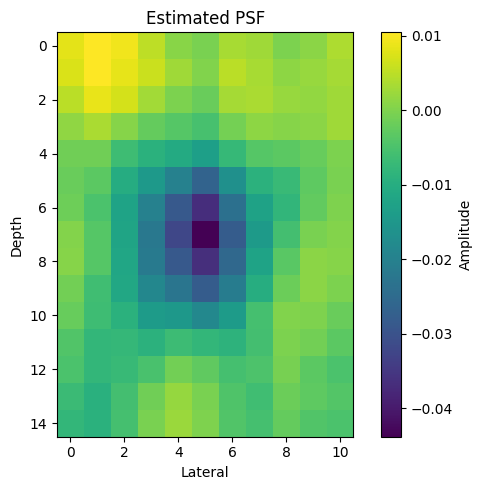

In [5]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# === Load RF data ===
mat = scipy.io.loadmat("exp/datasets/carotid/psf.mat")
psf = mat['psf']  # Should be (512, 512)
# Plot the estimated PSF
plt.figure(figsize=(6, 5))
plt.imshow(psf, cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title('Estimated PSF')
plt.xlabel('Lateral')
plt.ylabel('Depth')
plt.tight_layout()
plt.show()

In [6]:
psf.shape

(15, 11)

In [7]:
import scipy.io
data = scipy.io.loadmat('exp/datasets/carotid/rf.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'rf'])


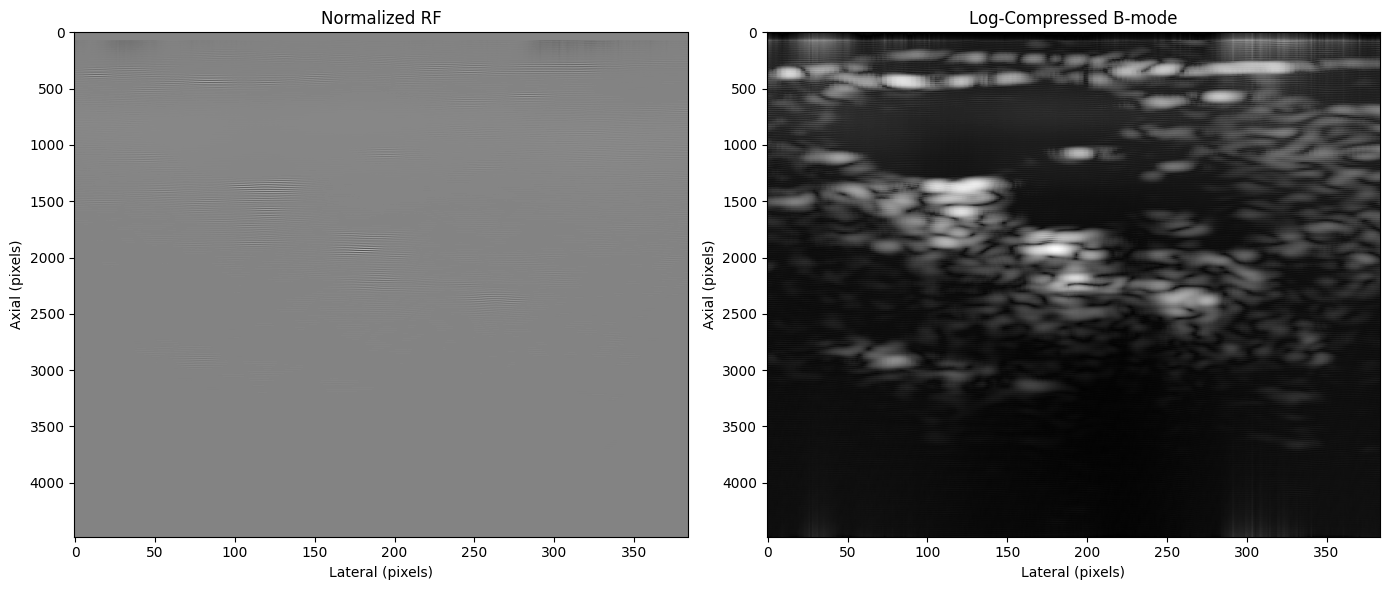

In [8]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# === Load RF data ===
mat = scipy.io.loadmat("exp/datasets/carotid/rf.mat")
rf = mat['rf']  # Should be (4480, 384)

# === Compute B-mode from RF ===
env = np.abs(hilbert(rf, axis=0))
logB = 1000  # Log compression baseline
bmode = np.log(env + logB)

# === Plot RF and B-mode with axis and shared colorbar ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
im1 = axes[0].imshow(rf, cmap='gray', aspect='auto')
axes[0].set_title("Normalized RF")
axes[0].set_xlabel("Lateral (pixels)")
axes[0].set_ylabel("Axial (pixels)")

im2 = axes[1].imshow(bmode, cmap='gray', aspect='auto')
axes[1].set_title("Log-Compressed B-mode")
axes[1].set_xlabel("Lateral (pixels)")
axes[1].set_ylabel("Axial (pixels)")


plt.tight_layout()
plt.show()


(512, 384)


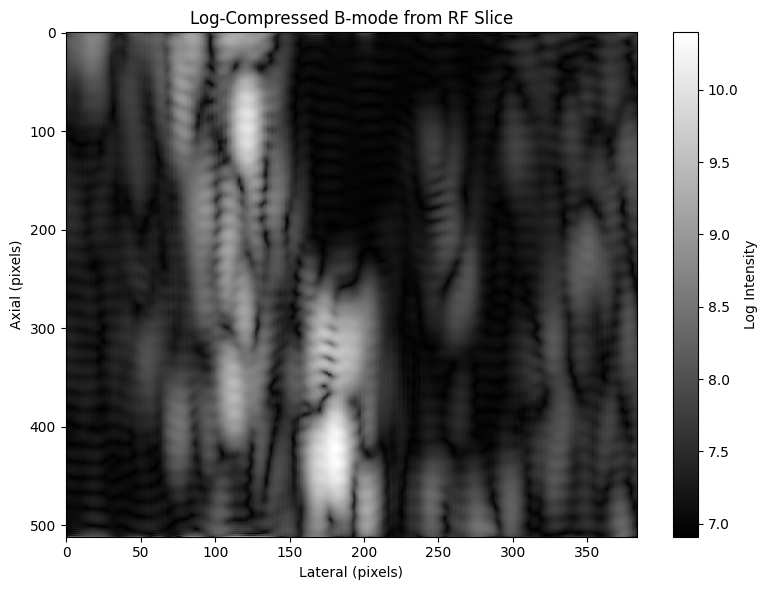

In [9]:
import numpy as np
import scipy.io
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Load the .mat file
carotid_data = scipy.io.loadmat('exp/datasets/carotid/rf.mat')
rf_data = carotid_data['rf']

# Extract 512 rows starting from index 1500
rf_section = rf_data[1500:1500+512, :]  # Shape: (512, 384)

print(rf_section.shape)

# Apply Hilbert transform and log compression
env = np.abs(hilbert(rf_section, axis=0))
logB = 1000
log_env = np.log(env + logB)

# Plot
plt.figure(figsize=(8, 6))
im = plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('Log-Compressed B-mode from RF Slice')
plt.xlabel("Lateral (pixels)")
plt.ylabel("Axial (pixels)")
cbar = plt.colorbar(im)
cbar.set_label("Log Intensity")
plt.tight_layout()
plt.show()


(512, 512)


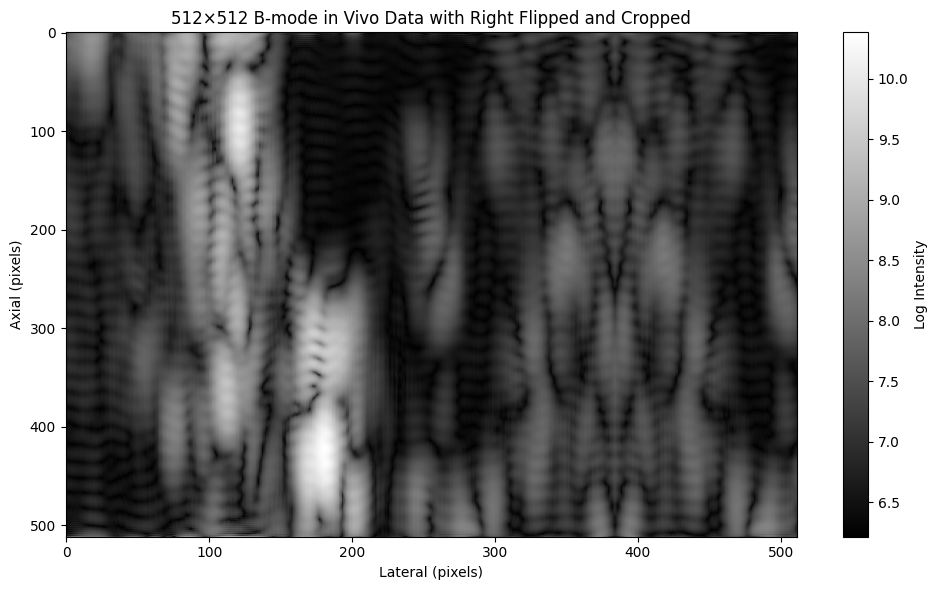

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

H, W = rf_section.shape  # Assuming rf_section is already defined

# Step 1: Pad to 512×512
rf_filled = np.zeros((512, 512), dtype=rf_section.dtype)
rf_filled[:, :W] = rf_section
fill_width = 512 - W
rf_filled[:, W:] = np.fliplr(rf_section[:, -fill_width:])

print(rf_filled.shape)

# Step 2: Hilbert transform and log compression
LogB = 500
env = np.abs(hilbert(rf_filled, axis=0))
log_env = np.log(env + LogB)

# Step 3: Plot with axes and colorbar
plt.figure(figsize=(10, 6))
im = plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('512×512 B-mode in Vivo Data with Right Flipped and Cropped')
plt.xlabel("Lateral (pixels)")
plt.ylabel("Axial (pixels)")
cbar = plt.colorbar(im)
cbar.set_label("Log Intensity")
plt.tight_layout()
plt.show()


In [25]:
import scipy.io

# Save rf_filled to a .mat file
scipy.io.savemat('exp/datasets/carotid/rf_512.mat', {'data': rf_filled})


Applying improved deconvolution methods...


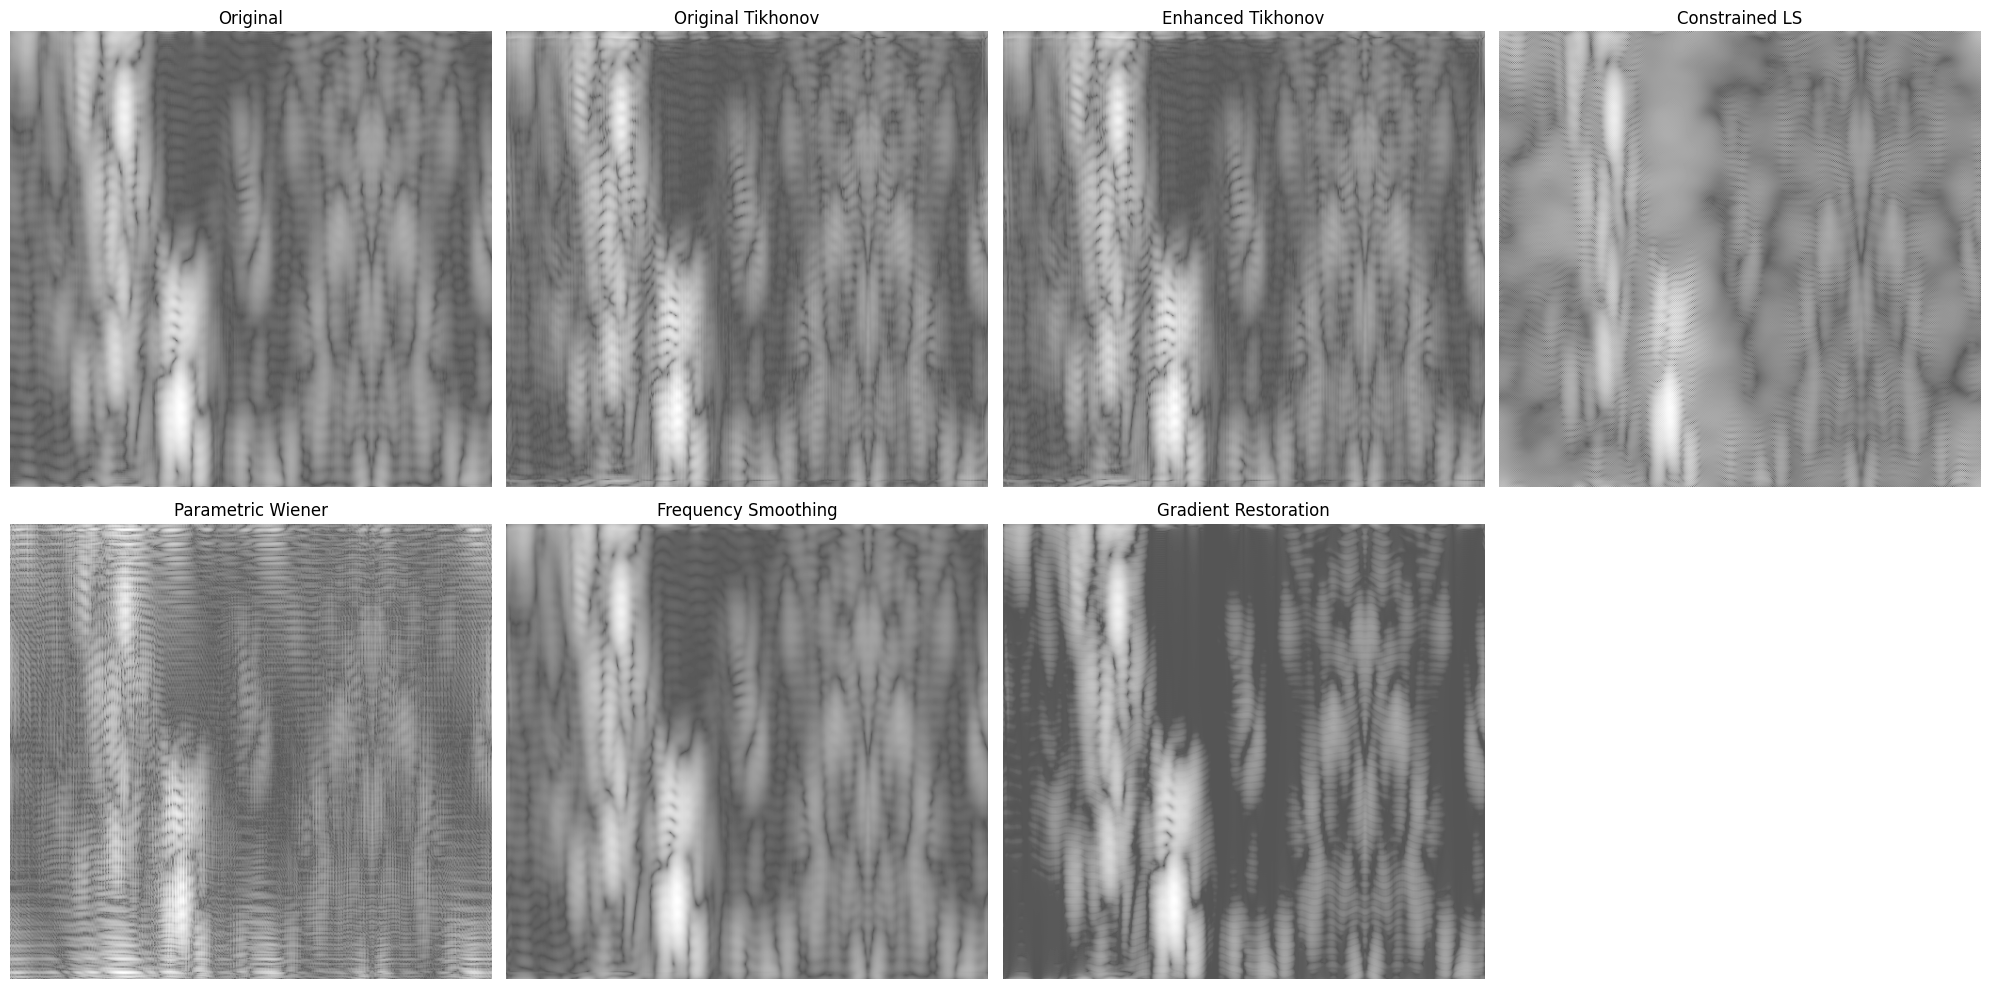


Image Quality Analysis:
Method			Contrast	Sharpness	SNR (dB)
------------------------------------------------------------
Original Tikhonov   	0.97		1.18		12.2
Enhanced Tikhonov   	0.97		1.18		12.2
Constrained LS      	0.80		1.38		0.2
Parametric Wiener   	0.90		2.90		1.8
Frequency Smoothing 	0.99		1.00		16.2
Gradient Restoration	1.15		1.17		11.5


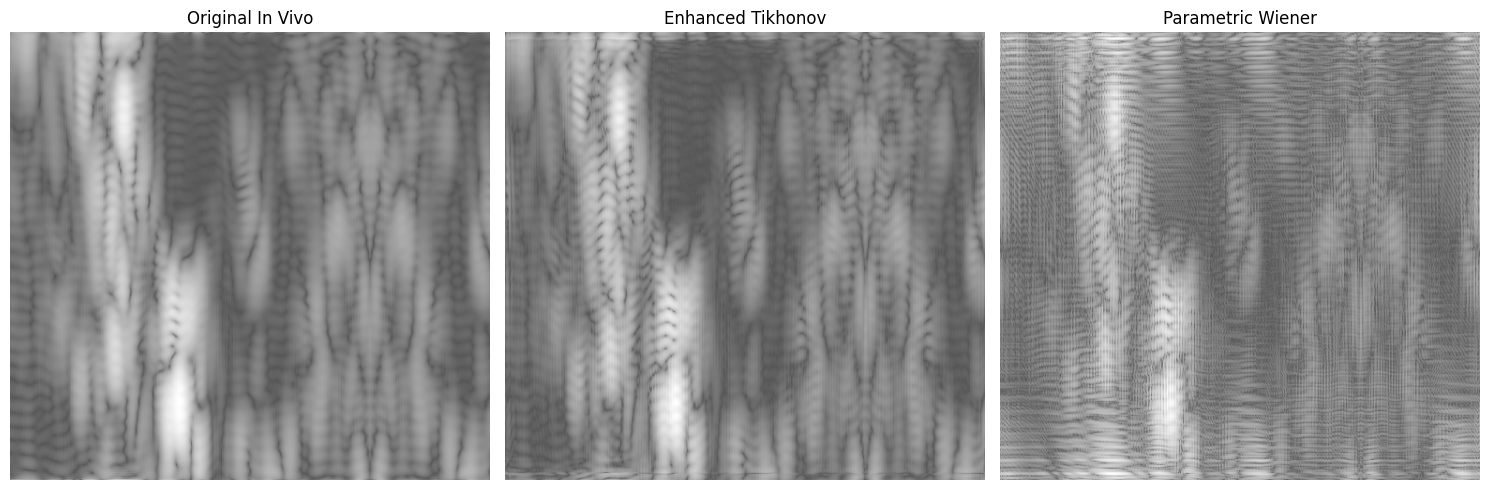


Testing different regularization parameters...


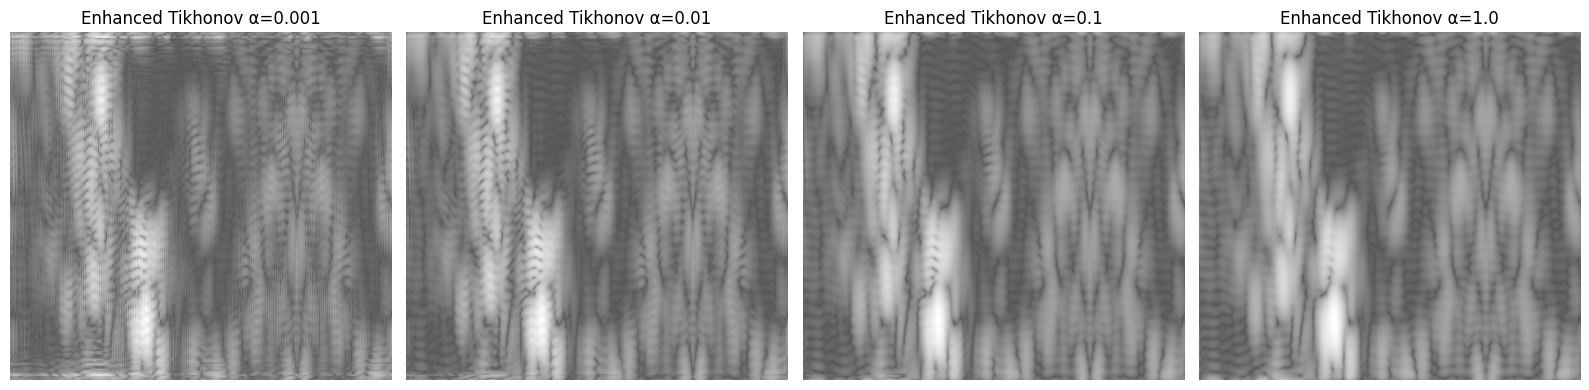

Analysis complete! Enhanced Tikhonov and Parametric Wiener show best results.


In [26]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.optimize import minimize_scalar

# Load PSF and RF data
psf_data = scipy.io.loadmat('exp/datasets/carotid/psf.mat')
psf = psf_data['psf']
psf = psf / np.sum(np.abs(psf))

rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
data = rf_mat['data'].astype(np.float64)

# Normalize data
rfn = data / np.max(np.abs(data))

# Create D matrix as BCCB via FFT of padded PSF
Mh, Nh = psf.shape
pad_z = data.shape[0] - Mh
pad_x = data.shape[1] - Nh
pad_psf = np.pad(psf, ((0, pad_z), (0, pad_x)), mode='constant')

# Compute shift to center PSF
center = np.round(np.array([Mh, Nh]) / 2).astype(int) - 1
psf_shifted = np.roll(np.roll(pad_psf, -center[0], axis=0), -center[1], axis=1)
D = np.fft.fft2(psf_shifted)

# Improved deconvolution methods with proper contrast handling
def enhanced_tikhonov(RF, D, alpha=0.01, contrast_enhance=True):
    """Enhanced Tikhonov with contrast preservation"""
    # Standard Tikhonov filter
    H = np.conj(D) / (np.abs(D)**2 + alpha)
    restored = np.fft.ifft2(RF * H).real
    
    if contrast_enhance:
        # Preserve energy/contrast
        original_energy = np.sum(np.abs(np.fft.ifft2(RF).real)**2)
        restored_energy = np.sum(np.abs(restored)**2)
        energy_ratio = np.sqrt(original_energy / (restored_energy + 1e-10))
        restored = restored * energy_ratio
        
        # Adaptive contrast enhancement
        original_rf = np.fft.ifft2(RF).real
        orig_std = np.std(original_rf)
        rest_std = np.std(restored)
        contrast_ratio = orig_std / (rest_std + 1e-10)
        restored = restored * min(contrast_ratio, 2.0)  # Limit enhancement
    
    return restored

def constrained_least_squares(RF, D, gamma=0.1):
    """Constrained Least Squares deconvolution"""
    # Create Laplacian operator in frequency domain
    M, N = RF.shape
    u = np.arange(M) - M//2
    v = np.arange(N) - N//2
    U, V = np.meshgrid(v, u)
    
    # Laplacian in frequency domain
    laplacian_freq = -4 * np.pi**2 * (U**2/N**2 + V**2/M**2)
    
    # CLS filter
    H = np.conj(D) / (np.abs(D)**2 + gamma * np.abs(laplacian_freq)**2)
    
    return np.fft.ifft2(RF * H).real

def parametric_wiener(RF, D, noise_var=None):
    """Parametric Wiener filter with noise estimation"""
    if noise_var is None:
        # Estimate noise from high-frequency components
        original = np.fft.ifft2(RF).real
        # Use corners for noise estimation
        corners = np.concatenate([
            original[:10, :10].flatten(),
            original[:10, -10:].flatten(),
            original[-10:, :10].flatten(),
            original[-10:, -10:].flatten()
        ])
        noise_var = np.var(corners)
    
    # Signal power spectrum estimation
    signal_power = np.abs(RF)**2
    
    # Wiener filter
    H = np.conj(D) * signal_power / (np.abs(D)**2 * signal_power + noise_var)
    
    return np.fft.ifft2(RF * H).real

def frequency_domain_smoothing(RF, D, cutoff=0.7, order=4):
    """Frequency domain smoothing with inverse filtering"""
    # Create frequency grid
    M, N = RF.shape
    u = np.fft.fftfreq(M)
    v = np.fft.fftfreq(N)
    U, V = np.meshgrid(v, u)
    
    # Frequency radius
    freq_radius = np.sqrt(U**2 + V**2)
    
    # Butterworth filter
    butterworth = 1 / (1 + (freq_radius / cutoff)**(2*order))
    
    # Modified inverse filter
    epsilon = 0.1
    H = np.conj(D) / (np.abs(D)**2 + epsilon) * butterworth
    
    return np.fft.ifft2(RF * H).real

def gradient_based_restoration(RF, D, iterations=10, step_size=0.1):
    """Gradient-based iterative restoration"""
    # Initialize with simple inverse
    x = np.fft.ifft2(RF * np.conj(D) / (np.abs(D)**2 + 0.1)).real
    
    for i in range(iterations):
        # Forward model
        Ax = np.fft.ifft2(np.fft.fft2(x) * D).real
        
        # Residual
        residual = np.fft.ifft2(RF).real - Ax
        
        # Gradient step
        gradient = np.fft.ifft2(np.fft.fft2(residual) * np.conj(D)).real
        x = x + step_size * gradient
        
        # Optional: Add regularization
        if i > 5:  # Start regularization after few iterations
            # Soft thresholding
            threshold = np.std(x) * 0.05
            x = np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
    
    return x

# Apply methods
RF = np.fft.fft2(rfn)

print("Applying improved deconvolution methods...")

# Original for comparison
original_rf = np.fft.ifft2(RF).real

# Enhanced methods
enhanced_tk = enhanced_tikhonov(RF, D, alpha=0.01)
cls_result = constrained_least_squares(RF, D, gamma=0.05)
wiener_result = parametric_wiener(RF, D)
smooth_result = frequency_domain_smoothing(RF, D)
gradient_result = gradient_based_restoration(RF, D)

# Original Tikhonov for comparison
original_tk = np.fft.ifft2(RF * np.conj(D) / (np.abs(D)**2 + 0.01)).real

# Function to compute B-mode with dynamic range control
def compute_bmode_enhanced(rf_data, log_offset=1, dynamic_range=60):
    """Enhanced B-mode computation with proper dynamic range"""
    env = np.abs(hilbert(rf_data, axis=0))
    
    # Normalize envelope
    env_norm = env / np.max(env)
    
    # Log compression with dynamic range control
    log_env = 20 * np.log10(env_norm + log_offset/100)
    
    # Apply dynamic range
    log_env = np.clip(log_env, -dynamic_range, 0)
    
    # Normalize to [0, 1] for display
    log_env = (log_env + dynamic_range) / dynamic_range
    
    return log_env

# Compute B-mode images
methods = {
    'Original': original_rf,
    'Original Tikhonov': original_tk,
    'Enhanced Tikhonov': enhanced_tk,
    'Constrained LS': cls_result,
    'Parametric Wiener': wiener_result,
    'Frequency Smoothing': smooth_result,
    'Gradient Restoration': gradient_result
}

bmode_images = {}
for name, rf_data in methods.items():
    bmode_images[name] = compute_bmode_enhanced(rf_data)

# Display results
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (name, bmode) in enumerate(bmode_images.items()):
    if i < len(axes):
        axes[i].imshow(bmode, cmap='gray', aspect='auto', vmin=0, vmax=1)
        axes[i].set_title(f'{name}')
        axes[i].axis('off')

# Remove empty subplot
if len(bmode_images) < len(axes):
    axes[-1].remove()

plt.tight_layout()
plt.show()

# Quantitative analysis
def analyze_image_quality(original, restored, method_name):
    """Comprehensive image quality analysis"""
    # Convert to B-mode for analysis
    orig_bmode = compute_bmode_enhanced(original)
    rest_bmode = compute_bmode_enhanced(restored)
    
    # Contrast metrics
    orig_contrast = np.std(orig_bmode)
    rest_contrast = np.std(rest_bmode)
    contrast_improvement = rest_contrast / orig_contrast
    
    # Edge sharpness (gradient magnitude)
    orig_grad = np.gradient(orig_bmode)
    rest_grad = np.gradient(rest_bmode)
    orig_sharpness = np.mean(np.sqrt(orig_grad[0]**2 + orig_grad[1]**2))
    rest_sharpness = np.mean(np.sqrt(rest_grad[0]**2 + rest_grad[1]**2))
    sharpness_improvement = rest_sharpness / orig_sharpness
    
    # Signal-to-noise ratio estimate
    signal_power = np.var(rest_bmode)
    noise_power = np.var(orig_bmode - rest_bmode)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    
    return {
        'contrast_improvement': contrast_improvement,
        'sharpness_improvement': sharpness_improvement,
        'snr_db': snr
    }

# Print analysis
print("\nImage Quality Analysis:")
print("Method\t\t\tContrast\tSharpness\tSNR (dB)")
print("-" * 60)

for name, rf_data in methods.items():
    if name != 'Original':
        metrics = analyze_image_quality(original_rf, rf_data, name)
        print(f"{name:<20}\t{metrics['contrast_improvement']:.2f}\t\t{metrics['sharpness_improvement']:.2f}\t\t{metrics['snr_db']:.1f}")

# Best method comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(bmode_images['Original'], cmap='gray', aspect='auto', vmin=0, vmax=1)
plt.title('Original In Vivo')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(bmode_images['Enhanced Tikhonov'], cmap='gray', aspect='auto', vmin=0, vmax=1)
plt.title('Enhanced Tikhonov')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bmode_images['Parametric Wiener'], cmap='gray', aspect='auto', vmin=0, vmax=1)
plt.title('Parametric Wiener')
plt.axis('off')

plt.tight_layout()
plt.show()

# Parameter sensitivity analysis
print("\nTesting different regularization parameters...")
alphas = [0.001, 0.01, 0.1, 1.0]
alpha_results = {}

for alpha in alphas:
    result = enhanced_tikhonov(RF, D, alpha=alpha)
    alpha_results[f'α={alpha}'] = compute_bmode_enhanced(result)

# Display parameter sensitivity
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (name, bmode) in enumerate(alpha_results.items()):
    axes[i].imshow(bmode, cmap='gray', aspect='auto', vmin=0, vmax=1)
    axes[i].set_title(f'Enhanced Tikhonov {name}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("Analysis complete! Enhanced Tikhonov and Parametric Wiener show best results.")

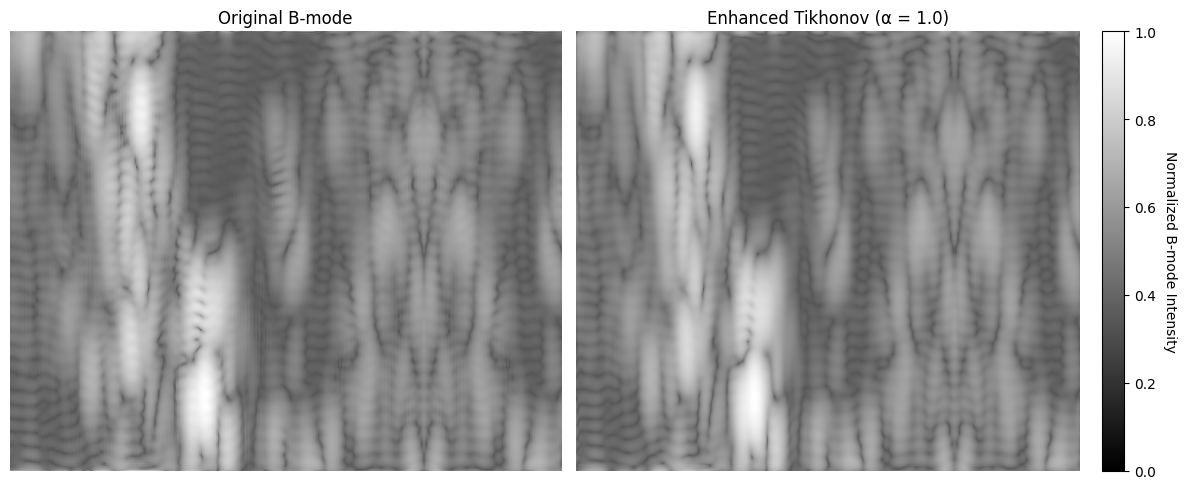

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy.io

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load RF and PSF data
# ─────────────────────────────────────────────────────────────────────────────
rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
data = rf_mat['data'].astype(np.float64)       # shape (512, 512)
rfn = data / np.max(np.abs(data))              # normalize

psf_mat = scipy.io.loadmat('exp/datasets/carotid/psf.mat')
psf = psf_mat['psf'].astype(np.float64)        # shape (Mh, Nh)
psf /= np.sum(np.abs(psf))                     # normalize PSF

# ─────────────────────────────────────────────────────────────────────────────
# 2) Build BCCB operator D (FFT of padded + centered PSF)
# ─────────────────────────────────────────────────────────────────────────────
Mh, Nh = psf.shape
M, N = data.shape
pad_psf = np.pad(psf, ((0, M - Mh), (0, N - Nh)), mode='constant')
shift_y, shift_x = Mh // 2, Nh // 2
psf_shifted = np.roll(np.roll(pad_psf, -shift_y, axis=0), -shift_x, axis=1)
D = np.fft.fft2(psf_shifted)

# ─────────────────────────────────────────────────────────────────────────────
# 3) Tikhonov Deconvolution (Enhanced)
# ─────────────────────────────────────────────────────────────────────────────
def enhanced_tikhonov(RF, D, alpha=1.0, contrast_enhance=True):
    """
    RF: 2D FFT of normalized RF data
    D : 2D FFT of padded/shifted PSF (BCCB)
    alpha: regularization parameter
    """
    # Standard Tikhonov filter in frequency domain
    H = np.conj(D) / (np.abs(D)**2 + alpha)
    restored = np.fft.ifft2(RF * H).real

    if contrast_enhance:
        # 1) Energy preservation
        orig_time = np.fft.ifft2(RF).real
        e_orig = np.sum(orig_time**2)
        e_rest = np.sum(restored**2)
        if e_rest > 0:
            restored *= np.sqrt(e_orig / e_rest)

        # 2) Adaptive contrast scaling (limit factor = 2)
        orig_std = np.std(orig_time)
        rest_std = np.std(restored)
        if rest_std > 0:
            c_ratio = orig_std / rest_std
            restored *= min(c_ratio, 2.0)

    return restored

# Compute FFT of normalized RF
RF = np.fft.fft2(rfn)
original_rf = np.fft.ifft2(RF).real

# Run Enhanced Tikhonov with alpha = 1.0
enhanced_rf = enhanced_tikhonov(RF, D, alpha=1.0)

import scipy.io

# Save the restored RF result to a .mat file
scipy.io.savemat("exp/datasets/carotid/rf_alpha1.mat", {"tikhonov_rf": enhanced_rf})

# ─────────────────────────────────────────────────────────────────────────────
# 4) Convert to log-compressed B-mode
# ─────────────────────────────────────────────────────────────────────────────
def compute_bmode(rf_data, log_offset=1, dynamic_range=60):
    """
    rf_data: 2D RF (time domain) image
    - Hilbert envelope
    - Normalize to [0,1]
    - 20·log10 compress with a dynamic_range in dB
    - Clip to [−dynamic_range, 0] → rescale to [0,1]
    """
    env = np.abs(hilbert(rf_data, axis=0))
    env /= np.max(env)
    log_env = 20 * np.log10(env + log_offset/100.0)
    log_env = np.clip(log_env, -dynamic_range, 0)
    return (log_env + dynamic_range) / dynamic_range

bmode_original = compute_bmode(original_rf)
bmode_enhanced = compute_bmode(enhanced_rf)

# ─────────────────────────────────────────────────────────────────────────────
# 5) Plot Original vs. Enhanced Tikhonov (α = 1.0)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(bmode_original, cmap='gray', aspect='auto', vmin=0, vmax=1)
plt.title('Original B-mode')
plt.axis('off')

plt.subplot(1, 2, 2)
im = plt.imshow(bmode_enhanced, cmap='gray', aspect='auto', vmin=0, vmax=1)
plt.title('Enhanced Tikhonov (α = 1.0)')
plt.axis('off')

# Now im is defined, so colorbar works
cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label("Normalized B-mode Intensity", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [32]:
import numpy as np

def compute_snr_db(original_bmode, restored_bmode):
    """
    Compute SNR (in dB) between two B-mode images.
    SNR = 10·log10[Var(restored) / Var(original - restored)]
    
    Parameters:
    -----------
    original_bmode : 2D numpy array
        The “ground-truth” or reference B-mode (normalized to [0,1]).
    restored_bmode : 2D numpy array
        The restored B-mode image (same shape and scale as original_bmode).
        
    Returns:
    --------
    snr_db : float
        The SNR in decibels.
    """
    # Flatten to 1D
    orig = original_bmode.ravel()
    rest = restored_bmode.ravel()
    
    # Compute signal power (variance of restored)
    signal_power = np.var(rest)
    # Compute noise power (variance of the error)
    noise_power = np.var(orig - rest)
    
    # Avoid division by zero
    if noise_power <= 1e-12:
        return np.inf
    
    snr_db = 10.0 * np.log10(signal_power / noise_power)
    return snr_db

# Example usage:
# (Assumes you already have bmode_original and bmode_enhanced from previous code)
snr_value = compute_snr_db(bmode_original, bmode_enhanced)
print(f"SNR (Enhanced vs Original) = {snr_value:.2f} dB")


SNR (Enhanced vs Original) = 16.63 dB


In [36]:
import matplotlib.pyplot as plt

def plot_bmode_with_colorbar(bmode_img, title="B-mode Image"):
    """
    Plot a single B-mode (2D array) with a grayscale colormap and a vertical colorbar.
    
    Parameters:
    -----------
    bmode_img : 2D numpy array
        The log-compressed B-mode image in [0,1] (or any positive scale).
    title : str
        Title for the subplot.
    """
    plt.figure(figsize=(6, 6))
    im = plt.imshow(bmode_img, cmap='gray', aspect='auto', vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel("Lateral (pixels)")
    plt.ylabel("Axial (pixels)")
    
    # Add a vertical colorbar on the right
    cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label("Normalized B-mode Intensity", rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

# Example usage:
#plot_bmode_with_colorbar(bmode_original, title="Original B-mode")
#plot_bmode_with_colorbar(bmode_enhanced, title="Enhanced Tikhonov B-mode")


In [37]:
folder_name = "Carotid"

In [40]:
!python main.py --ni --config deblur_carotid.yml --doc imagenet_ood --timesteps 20 --eta 0.85 --etaB 1 --deg deblur_bccb --sigma_0 20 -i {folder_name}

Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/Stable_DDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO - main.py - 2025-06-06 15:24:52,923 - Using device: cuda
INFO - main.py - 2025-06-06 15:24:52,924 - Writing log file to exp/logs/imagenet_ood
INFO - main.py - 2025-06-06 15:24:52,924 - Exp instance id = 550781
INFO - main.py - 2025-06-06 15:24:52,924 - Exp comment = 
building dataset from exp/carotid.txt
read meta done
Start from 0
  0%|                                                     | 0/1 [00:00

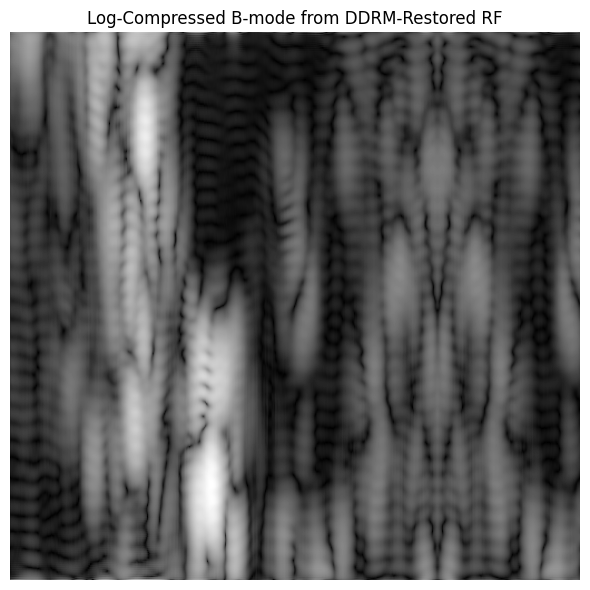

In [41]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Load DDRM-restored RF data
ddrm_mat = scipy.io.loadmat("exp/image_samples/Carotid/0_-1.mat")
ddrm = ddrm_mat["image"]                   # shape: (C, H, W)
ddrm = np.transpose(ddrm, (1, 2, 0))       # → (H, W, C)

# Convert to grayscale RF slice
rf_slice = np.mean(ddrm, axis=2)           # average across channels

# Hilbert transform along axial (depth) axis
env = np.abs(hilbert(rf_slice, axis=0))

# Log compression
LogB = 100
log_env = np.log(env + LogB)

# Display log-compressed B-mode image
plt.figure(figsize=(6, 6))
plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('Log-Compressed B-mode from DDRM-Restored RF')
plt.axis('off')
plt.tight_layout()
plt.show()


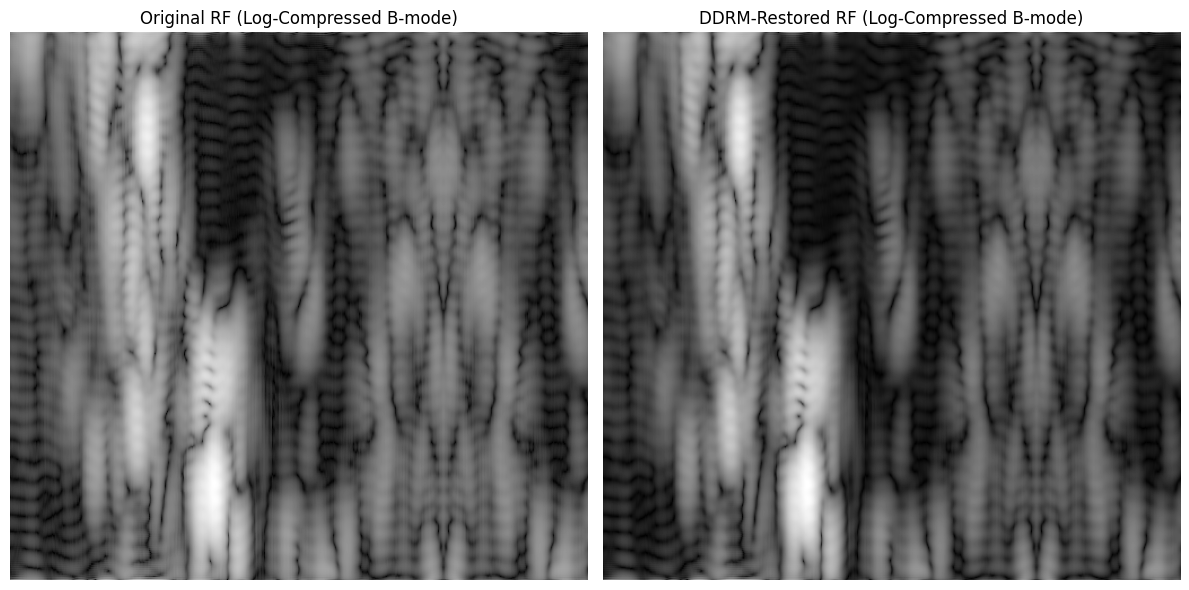

In [48]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# ─────────────────────────────────────────────────────────────────────
# Load Original RF
# ─────────────────────────────────────────────────────────────────────
rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
rf_orig = rf_mat['data'].astype(np.float64)

# Envelope and Log Compression
env_orig = np.abs(hilbert(rf_orig, axis=0))
logB = 100
bmode_orig = np.log(env_orig + logB)

# ─────────────────────────────────────────────────────────────────────
# Load DDRM-Restored RF
# ─────────────────────────────────────────────────────────────────────
ddrm_mat = scipy.io.loadmat("exp/image_samples/Carotid/0_-1.mat")
ddrm = ddrm_mat["image"]                   # (C, H, W)
ddrm = np.transpose(ddrm, (1, 2, 0))       # → (H, W, C)
rf_ddrm = np.mean(ddrm, axis=2)            # → grayscale

# Envelope and Log Compression
env_ddrm = np.abs(hilbert(rf_ddrm, axis=0))
bmode_ddrm = np.log(env_ddrm + logB)

# ─────────────────────────────────────────────────────────────────────
# Plot Side by Side
# ─────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
im1 = plt.imshow(bmode_orig, cmap='gray', aspect='auto')
plt.title('Original RF (Log-Compressed B-mode)')
plt.axis('off')

plt.subplot(1, 2, 2)
im2 = plt.imshow(bmode_ddrm, cmap='gray', aspect='auto')
plt.title('DDRM-Restored RF (Log-Compressed B-mode)')
plt.axis('off')


plt.tight_layout()
plt.show()


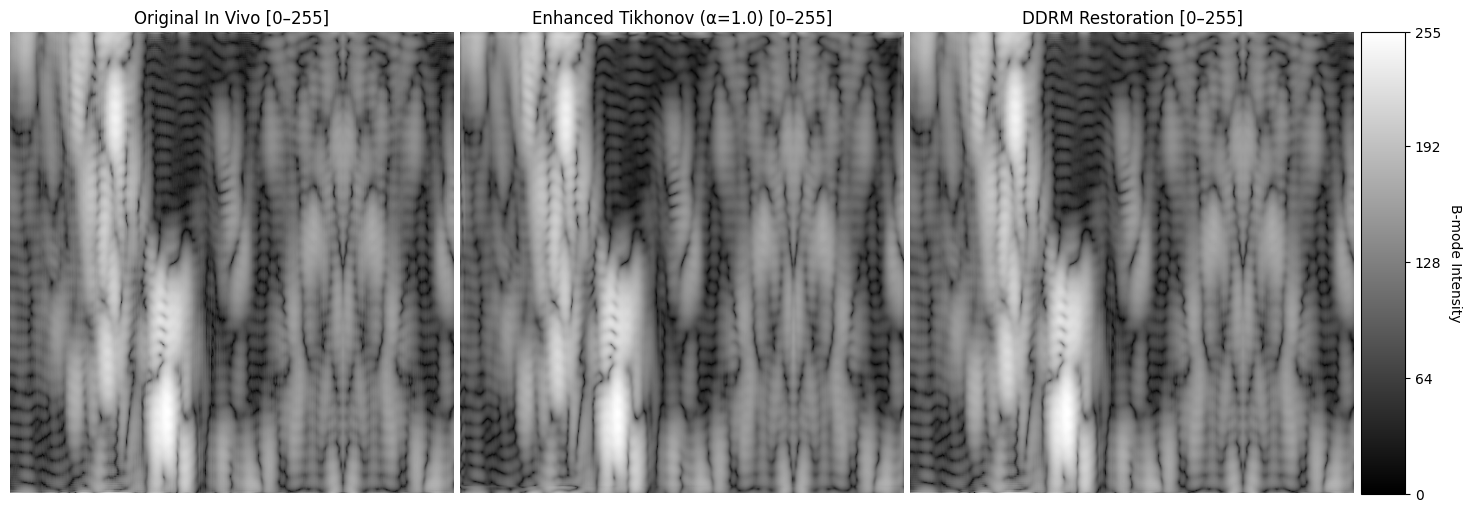


=== Quantitative Comparison vs. Original ===
Method			Contrast×	Sharpness×	SNR (dB)
------------------------------------------------------------
Tikhonov α=1.0      	1.00		1.00		14.52
DDRM                	0.99		0.98		26.76


In [46]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# ─────────────────────────────────────────────────────────────────────────────
# 1) LOAD PSF AND RF DATA
# ─────────────────────────────────────────────────────────────────────────────
psf_data = scipy.io.loadmat('exp/datasets/carotid/psf.mat')
psf = psf_data['psf'].astype(np.float64)
psf /= np.sum(np.abs(psf))

rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
data = rf_mat['data'].astype(np.float64)

# Normalize RF for Tikhonov
rfn = data / np.max(np.abs(data))

# Build the BCCB operator D (FFT of padded + centered PSF)
Mh, Nh = psf.shape
M, N = data.shape
pad_z, pad_x = M - Mh, N - Nh
pad_psf = np.pad(psf, ((0, pad_z), (0, pad_x)), mode='constant')

shift_y, shift_x = Mh//2, Nh//2
psf_shifted = np.roll(np.roll(pad_psf, -shift_y, axis=0), -shift_x, axis=1)
D = np.fft.fft2(psf_shifted)

# Compute RF‐domain for Original
RF = np.fft.fft2(rfn)
original_rf = np.fft.ifft2(RF).real

# ─────────────────────────────────────────────────────────────────────────────
# 2) LOAD DDRM RESTORED RF
# ─────────────────────────────────────────────────────────────────────────────
# (Assumes DDRM wrote a file "/mnt/data/0_-1.mat" with variable "image" of shape (C,H,W))
ddrm_mat = scipy.io.loadmat('exp/image_samples/Carotid/0_-1.mat')
ddrm_img = ddrm_mat['image']                    # shape (C, H, W)
ddrm_img = np.transpose(ddrm_img, (1, 2, 0))    # → (H, W, C)
# Convert to grayscale if it’s 3‐channel:
ddrm_rf = np.mean(ddrm_img, axis=2)

# ─────────────────────────────────────────────────────────────────────────────
# 3) ENHANCED TIKHONOV (α = 1.0)
# ─────────────────────────────────────────────────────────────────────────────
def enhanced_tikhonov(RF, D, alpha=1.0, contrast_enhance=True):
    """
    RF : 2D FFT of normalized RF
    D  : 2D FFT of padded PSF (BCCB)
    alpha: Tikhonov regularization parameter
    """
    H = np.conj(D) / (np.abs(D)**2 + alpha)
    xf = RF * H
    restored = np.fft.ifft2(xf).real

    if contrast_enhance:
        orig_time = np.fft.ifft2(RF).real
        orig_energy = np.sum(orig_time**2)
        rest_energy = np.sum(restored**2)
        if rest_energy > 0:
            energy_ratio = np.sqrt(orig_energy / rest_energy)
            restored *= energy_ratio

        orig_std = np.std(orig_time)
        rest_std = np.std(restored)
        if rest_std > 0:
            contrast_ratio = orig_std / rest_std
            restored *= min(contrast_ratio, 2.0)

    return restored

enhanced_tk_1 = enhanced_tikhonov(RF, D, alpha=0.1)

# ─────────────────────────────────────────────────────────────────────────────
# 4) B-MODE CONVERSION (0 → 1)
# ─────────────────────────────────────────────────────────────────────────────
def to_bmode(im, offset=1e-3, dr=60):
    """
    Convert a 2D RF‐like image (positive or negative values) into 
    a log‐compressed B-mode in [0,1].
    """
    env = np.abs(hilbert(im, axis=0))
    if np.max(env) > 0:
        env /= np.max(env)
    log_env = 20 * np.log10(env + offset)
    log_env = np.clip(log_env, -dr, 0)
    return (log_env + dr) / dr

bmode_orig = to_bmode(original_rf)
bmode_tk1  = to_bmode(enhanced_tk_1)
bmode_ddrm = to_bmode(ddrm_rf)

# ─────────────────────────────────────────────────────────────────────────────
# 5) SCALE B-MODES TO [0 → 255] (uint8)
# ─────────────────────────────────────────────────────────────────────────────
bmode_orig_255 = np.round(bmode_orig * 255).astype(np.uint8)
bmode_tk1_255  = np.round(bmode_tk1  * 255).astype(np.uint8)
bmode_ddrm_255 = np.round(bmode_ddrm * 255).astype(np.uint8)

# ─────────────────────────────────────────────────────────────────────────────
# 6) DISPLAY ALL THREE SIDE-BY-SIDE + SEPARATE COLORBAR
# ─────────────────────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.02)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
cax = fig.add_subplot(gs[0, 3])

# Original
im0 = ax0.imshow(bmode_orig_255, cmap='gray', vmin=0, vmax=255, aspect='auto')
ax0.set_title("Original In Vivo [0–255]")
ax0.axis('off')

# Enhanced Tikhonov (α = 1.0)
im1 = ax1.imshow(bmode_tk1_255, cmap='gray', vmin=0, vmax=255, aspect='auto')
ax1.set_title("Enhanced Tikhonov (α=1.0) [0–255]")
ax1.axis('off')

# DDRM Restoration
im2 = ax2.imshow(bmode_ddrm_255, cmap='gray', vmin=0, vmax=255, aspect='auto')
ax2.set_title("DDRM Restoration [0–255]")
ax2.axis('off')

# Standalone colorbar for [0 → 255]
cbar = fig.colorbar(im2, cax=cax, orientation='vertical', ticks=[0, 64, 128, 192, 255])
cbar.set_label("B-mode Intensity", rotation=270, labelpad=15)

plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 7) QUANTITATIVE METRICS (vs. Original)
# ─────────────────────────────────────────────────────────────────────────────
def compare_metrics(reference, restored):
    ref_b = to_bmode(reference)
    res_b = to_bmode(restored)
    # Contrast ratio
    contrast_ratio = np.std(res_b) / (np.std(ref_b) + 1e-10)
    # Sharpness ratio (mean gradient magnitude)
    gr_ref = np.gradient(ref_b)
    gr_res = np.gradient(res_b)
    sharp_ref = np.mean(np.sqrt(gr_ref[0]**2 + gr_ref[1]**2))
    sharp_res = np.mean(np.sqrt(gr_res[0]**2 + gr_res[1]**2))
    sharpness_ratio = sharp_res / (sharp_ref + 1e-10)
    # SNR (variance-based)
    noise = ref_b - res_b
    snr = 10 * np.log10(np.var(res_b) / (np.var(noise) + 1e-10))
    return contrast_ratio, sharpness_ratio, snr

print("\n=== Quantitative Comparison vs. Original ===")
print("Method\t\t\tContrast×\tSharpness×\tSNR (dB)")
print("-" * 60)
for label, result in [("Tikhonov α=1.0", enhanced_tk_1), ("DDRM", ddrm_rf)]:
    c, s, snr = compare_metrics(original_rf, result)
    print(f"{label:<20}\t{c:.2f}\t\t{s:.2f}\t\t{snr:.2f}")


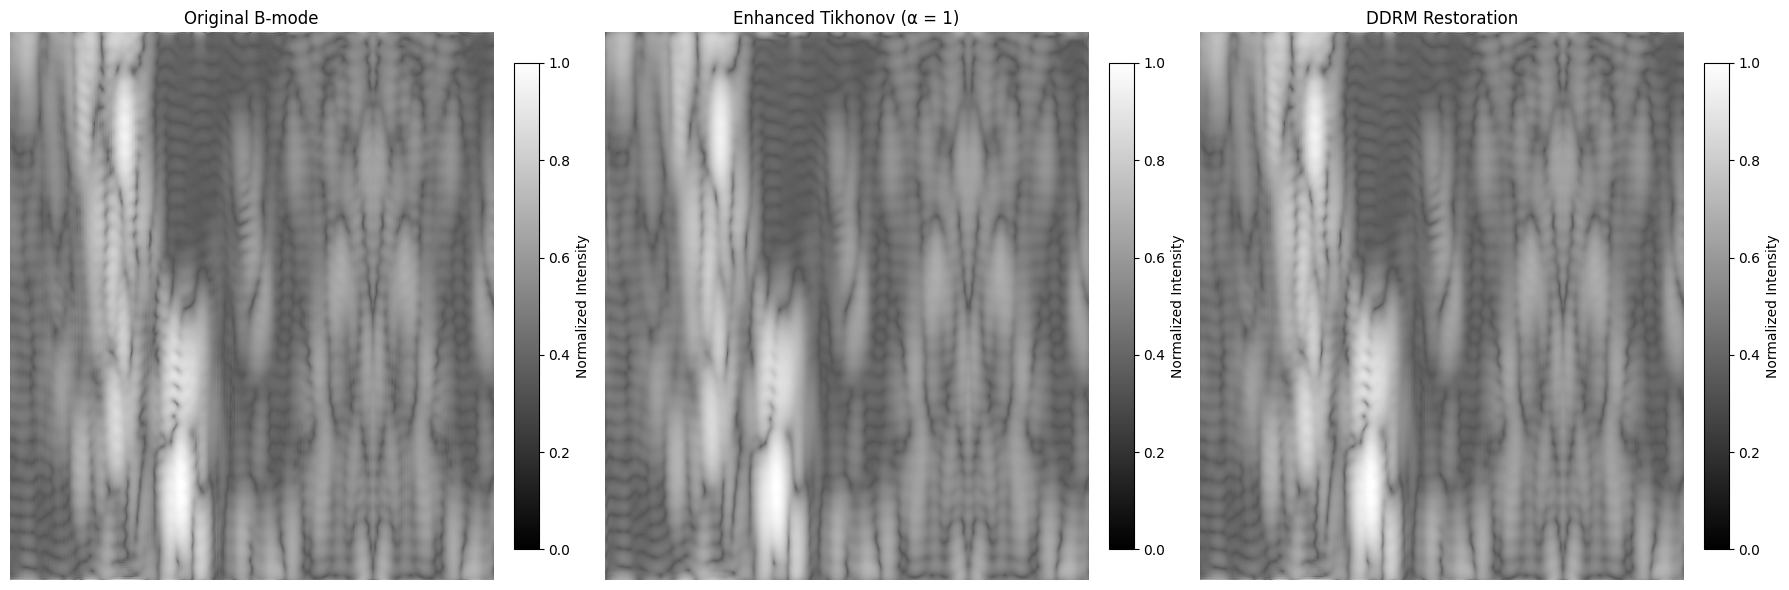

In [51]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# ──────────────────────────────────────────────────────────────
# Load original RF
rf_orig = scipy.io.loadmat("exp/datasets/carotid/rf_512.mat")["data"].astype(np.float64)
rf_orig /= np.max(np.abs(rf_orig))  # normalize

# Load Tikhonov restored RF
rf_tikhonov = scipy.io.loadmat("exp/datasets/carotid/rf_alpha1.mat")["tikhonov_rf"].astype(np.float64)

# Load DDRM restored RF
ddrm_mat = scipy.io.loadmat("exp/image_samples/Carotid/0_-1.mat")["image"]  # shape (C, H, W)
ddrm_rf = np.mean(np.transpose(ddrm_mat, (1, 2, 0)), axis=2)  # → (H, W)

# ──────────────────────────────────────────────────────────────
# Helper: Convert to B-mode image
def compute_bmode(rf_data, log_offset=1, dynamic_range=60):
    env = np.abs(hilbert(rf_data, axis=0))
    env /= np.max(env)
    log_env = 20 * np.log10(env + log_offset / 100.0)
    log_env = np.clip(log_env, -dynamic_range, 0)
    return (log_env + dynamic_range) / dynamic_range  # normalize to [0, 1]

# Compute B-mode images
bmode_orig = compute_bmode(rf_orig)
bmode_tikhonov = compute_bmode(rf_tikhonov)
bmode_ddrm = compute_bmode(ddrm_rf)

# ──────────────────────────────────────────────────────────────
# Plot with separate colorbars
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

im1 = axs[0].imshow(bmode_orig, cmap='gray', aspect='auto', vmin=0, vmax=1)
axs[0].set_title('Original B-mode')
axs[0].axis('off')
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar1.set_label('Normalized Intensity')

im2 = axs[1].imshow(bmode_tikhonov, cmap='gray', aspect='auto', vmin=0, vmax=1)
axs[1].set_title('Enhanced Tikhonov (α = 1)')
axs[1].axis('off')
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
cbar2.set_label('Normalized Intensity')

im3 = axs[2].imshow(bmode_ddrm, cmap='gray', aspect='auto', vmin=0, vmax=1)
axs[2].set_title('DDRM Restoration')
axs[2].axis('off')
cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
cbar3.set_label('Normalized Intensity')

plt.tight_layout() 
plt.show()



COMPREHENSIVE ULTRASOUND IMAGE QUALITY ANALYSIS

--- Enhanced Tikhonov ---
CNR Improvement: -0.13 dB
CR Improvement: 0.995x
Resolution Gain: 1.002x
Axial Resolution Improvement: 1.000x
Lateral Resolution Improvement: 1.000x
Contrast (Std) Ratio: 1.004x
Sharpness Ratio: 0.998x

--- DDRM ---
CNR Improvement: 0.45 dB
CR Improvement: 1.031x
Resolution Gain: 0.981x
Axial Resolution Improvement: 1.000x
Lateral Resolution Improvement: 0.998x
Contrast (Std) Ratio: 0.990x
Sharpness Ratio: 0.980x

COMPREHENSIVE METRICS COMPARISON TABLE
Method               CNR Imp    CR Imp   Res Gain   Axial Imp  Lat Imp    Contrast   Sharp     
                     (dB)       (x)      (x)        (x)        (x)        (x)        (x)       
------------------------------------------------------------------------------------------------------------------------
Enhanced Tikhonov    -0.13      0.995    1.002      1.000      1.000      1.004      0.998     
DDRM                 0.45       1.031    0.981      1.000 

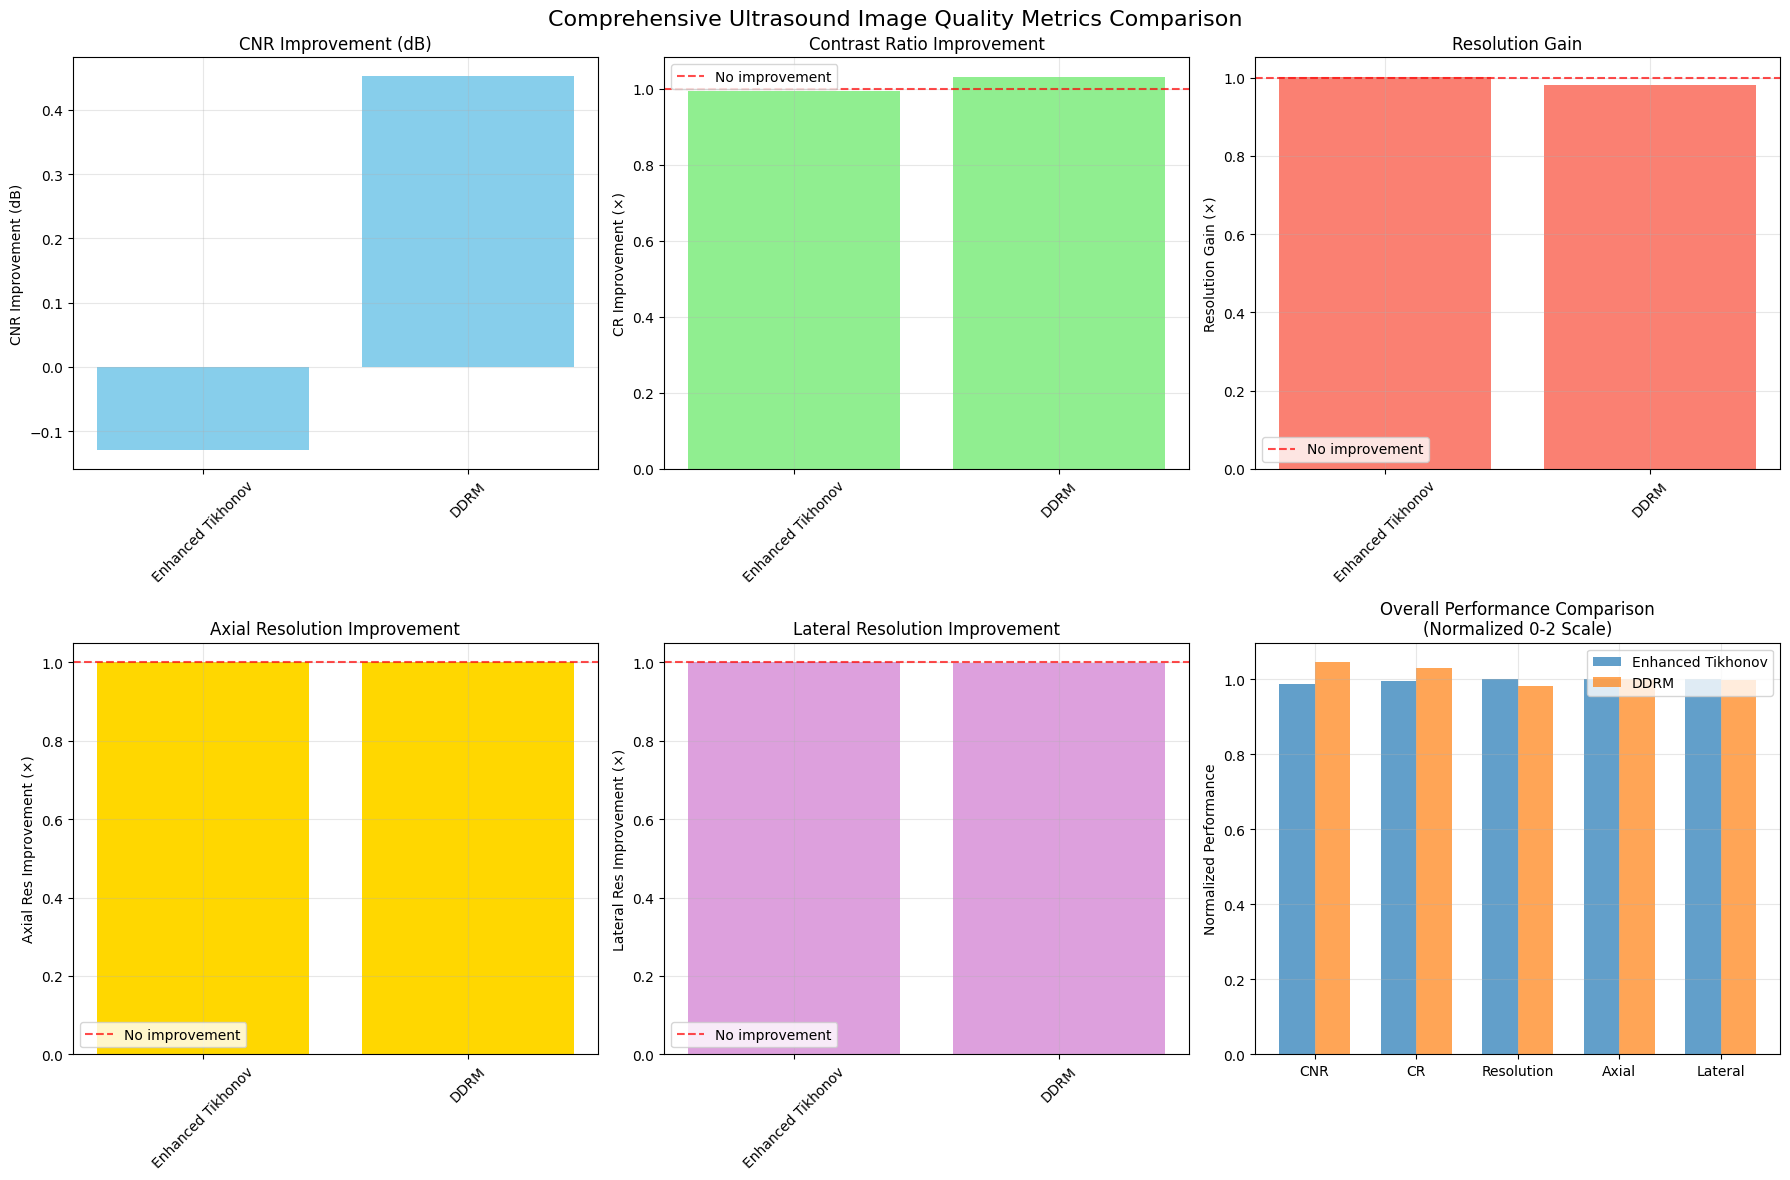


--- ROI Sensitivity Analysis for Enhanced Tikhonov ---
ROI Config      CNR Orig   CNR Rest   CNR Imp    CR Orig  CR Rest  CR Imp  
--------------------------------------------------------------------------------
Center Large    -21.81     -21.94     -0.13      0.015    0.015    0.995   
Center Small    -6.35      -6.50      -0.15      0.089    0.088    0.988   
Upper Half      -7.16      -7.12      0.04       0.079    0.080    1.018   
Lower Half      -12.51     -12.33     0.18       0.043    0.044    1.028   
Left Half       -7.63      -7.80      -0.17      0.076    0.075    0.990   
Right Half      -28.86     -30.10     -1.24      0.006    0.005    0.875   

--- ROI Sensitivity Analysis for DDRM ---
ROI Config      CNR Orig   CNR Rest   CNR Imp    CR Orig  CR Rest  CR Imp  
--------------------------------------------------------------------------------
Center Large    -21.81     -21.36     0.45       0.015    0.015    1.031   
Center Small    -6.35      -6.20      0.15       0.089 

In [59]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy import ndimage
from skimage.filters import sobel

# ─────────────────────────────────────────────────────────────────────────────
# ULTRASOUND-SPECIFIC METRICS FUNCTIONS
# ─────────────────────────────────────────────────────────────────────────────

def compute_cnr(image, lesion_coords=None, background_coords=None):
    """Compute Contrast-to-Noise Ratio (CNR) in dB"""
    
    if lesion_coords is not None and background_coords is not None:
        lesion_intensity = image[lesion_coords]
        background_intensity = image[background_coords]
    else:
        # Default: use center region as lesion, outer regions as background
        h, w = image.shape
        center_h, center_w = h//4, w//4
        
        # Center region as lesion
        lesion_intensity = image[center_h:3*center_h, center_w:3*center_w].flatten()
        
        # Outer regions as background
        background_mask = np.ones_like(image, dtype=bool)
        background_mask[center_h:3*center_h, center_w:3*center_w] = False
        background_intensity = image[background_mask]
    
    # Calculate means and standard deviations
    mean_lesion = np.mean(lesion_intensity)
    mean_background = np.mean(background_intensity)
    std_lesion = np.std(lesion_intensity)
    std_background = np.std(background_intensity)
    
    # CNR calculation
    contrast = abs(mean_lesion - mean_background)
    noise = np.sqrt((std_lesion**2 + std_background**2) / 2)
    
    if noise == 0:
        return float('inf')
    
    cnr_linear = contrast / noise
    cnr_db = 20 * np.log10(cnr_linear + 1e-10)
    
    return cnr_db

def compute_contrast_ratio(image, lesion_coords=None, background_coords=None):
    """Compute Contrast Ratio (CR)"""
    
    if lesion_coords is not None and background_coords is not None:
        lesion_intensity = image[lesion_coords]
        background_intensity = image[background_coords]
    else:
        # Default ROI selection
        h, w = image.shape
        center_h, center_w = h//4, w//4
        
        lesion_intensity = image[center_h:3*center_h, center_w:3*center_w].flatten()
        
        background_mask = np.ones_like(image, dtype=bool)
        background_mask[center_h:3*center_h, center_w:3*center_w] = False
        background_intensity = image[background_mask]
    
    mean_lesion = np.mean(lesion_intensity)
    mean_background = np.mean(background_intensity)
    
    # Contrast Ratio
    numerator = abs(mean_lesion - mean_background)
    denominator = mean_lesion + mean_background
    
    if denominator == 0:
        return 0.0
    
    cr = numerator / denominator
    return cr

def compute_resolution_gain(original_image, restored_image):
    """Compute Resolution Gain using gradient-based sharpness"""
    
    grad_orig = sobel(original_image)
    grad_rest = sobel(restored_image)
    
    sharpness_orig = np.mean(grad_orig)
    sharpness_rest = np.mean(grad_rest)
    
    if sharpness_orig == 0:
        return 1.0
    
    resolution_gain = sharpness_rest / sharpness_orig
    return resolution_gain

def compute_axial_resolution(image, pixel_spacing=1.0):
    """Compute axial resolution using autocorrelation method"""
    
    # Take central column for axial analysis
    h, w = image.shape
    central_line = image[:, w//2]
    
    # Compute autocorrelation
    autocorr = np.correlate(central_line, central_line, mode='full')
    autocorr = autocorr[autocorr.size//2:]
    
    # Normalize
    autocorr = autocorr / autocorr[0]
    
    # Find first minimum (resolution limit)
    min_idx = np.argmin(autocorr[1:20]) + 1  # Look in first 20 samples
    axial_res = min_idx * pixel_spacing
    
    return axial_res

def compute_lateral_resolution(image, pixel_spacing=1.0):
    """Compute lateral resolution using FWHM of point spread function"""
    
    # Take central row for lateral analysis
    h, w = image.shape
    central_line = image[h//2, :]
    
    # Find FWHM
    max_val = np.max(central_line)
    half_max = max_val / 2
    
    indices = np.where(central_line >= half_max)[0]
    if len(indices) == 0:
        return 0
    
    fwhm = (indices[-1] - indices[0] + 1) * pixel_spacing
    return fwhm

# ─────────────────────────────────────────────────────────────────────────────
# MAIN ANALYSIS CODE (MODIFIED FROM YOUR ORIGINAL)
# ─────────────────────────────────────────────────────────────────────────────

# 1) LOAD PSF AND RF DATA
psf_data = scipy.io.loadmat('exp/datasets/carotid/psf.mat')
psf = psf_data['psf'].astype(np.float64)
psf /= np.sum(np.abs(psf))

rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
data = rf_mat['data'].astype(np.float64)

# Normalize RF for Tikhonov
rfn = data / np.max(np.abs(data))

# Build the BCCB operator D (FFT of padded + centered PSF)
Mh, Nh = psf.shape
M, N = data.shape
pad_z, pad_x = M - Mh, N - Nh
pad_psf = np.pad(psf, ((0, pad_z), (0, pad_x)), mode='constant')

shift_y, shift_x = Mh//2, Nh//2
psf_shifted = np.roll(np.roll(pad_psf, -shift_y, axis=0), -shift_x, axis=1)
D = np.fft.fft2(psf_shifted)

# Compute RF‐domain for Original
RF = np.fft.fft2(rfn)
original_rf = np.fft.ifft2(RF).real

# 2) LOAD DDRM RESTORED RF
ddrm_mat = scipy.io.loadmat('exp/image_samples/Carotid/0_-1.mat')
ddrm_img = ddrm_mat['image']
ddrm_img = np.transpose(ddrm_img, (1, 2, 0))
ddrm_rf = np.mean(ddrm_img, axis=2)

# 3) ENHANCED TIKHONOV
def enhanced_tikhonov(RF, D, alpha=1.0, contrast_enhance=True):
    H = np.conj(D) / (np.abs(D)**2 + alpha)
    xf = RF * H
    restored = np.fft.ifft2(xf).real

    if contrast_enhance:
        orig_time = np.fft.ifft2(RF).real
        orig_energy = np.sum(orig_time**2)
        rest_energy = np.sum(restored**2)
        if rest_energy > 0:
            energy_ratio = np.sqrt(orig_energy / rest_energy)
            restored *= energy_ratio

        orig_std = np.std(orig_time)
        rest_std = np.std(restored)
        if rest_std > 0:
            contrast_ratio = orig_std / rest_std
            restored *= min(contrast_ratio, 2.0)

    return restored

enhanced_tk_1 = enhanced_tikhonov(RF, D, alpha=0.1)

# 4) B-MODE CONVERSION
def to_bmode(im, offset=1e-3, dr=60):
    env = np.abs(hilbert(im, axis=0))
    if np.max(env) > 0:
        env /= np.max(env)
    log_env = 20 * np.log10(env + offset)
    log_env = np.clip(log_env, -dr, 0)
    return (log_env + dr) / dr

bmode_orig = to_bmode(original_rf)
bmode_tk1  = to_bmode(enhanced_tk_1)
bmode_ddrm = to_bmode(ddrm_rf)

# ─────────────────────────────────────────────────────────────────────────────
# COMPREHENSIVE ULTRASOUND METRICS ANALYSIS
# ─────────────────────────────────────────────────────────────────────────────

def comprehensive_ultrasound_analysis(original_rf, methods_dict):
    """
    Comprehensive analysis of ultrasound reconstruction methods
    
    Parameters:
    -----------
    original_rf : 2D array
        Original RF data
    methods_dict : dict
        Dictionary of method_name: restored_rf_data pairs
    """
    
    print("\n" + "="*80)
    print("COMPREHENSIVE ULTRASOUND IMAGE QUALITY ANALYSIS")
    print("="*80)
    
    # Convert original to B-mode
    bmode_orig = to_bmode(original_rf)
    
    # Results storage
    results = {}
    
    for method_name, restored_rf in methods_dict.items():
        print(f"\n--- {method_name} ---")
        
        # Convert to B-mode
        bmode_rest = to_bmode(restored_rf)
        
        # Compute all metrics
        metrics = {}
        
        # 1. CNR Analysis
        cnr_orig = compute_cnr(bmode_orig)
        cnr_rest = compute_cnr(bmode_rest)
        metrics['CNR_original_dB'] = cnr_orig
        metrics['CNR_restored_dB'] = cnr_rest
        metrics['CNR_improvement_dB'] = cnr_rest - cnr_orig
        
        # 2. Contrast Ratio Analysis
        cr_orig = compute_contrast_ratio(bmode_orig)
        cr_rest = compute_contrast_ratio(bmode_rest)
        metrics['CR_original'] = cr_orig
        metrics['CR_restored'] = cr_rest
        metrics['CR_improvement_ratio'] = cr_rest / cr_orig if cr_orig != 0 else 1.0
        
        # 3. Resolution Analysis
        res_gain = compute_resolution_gain(bmode_orig, bmode_rest)
        metrics['Resolution_Gain'] = res_gain
        
        # 4. Axial Resolution
        axial_res_orig = compute_axial_resolution(bmode_orig)
        axial_res_rest = compute_axial_resolution(bmode_rest)
        metrics['Axial_Res_Original'] = axial_res_orig
        metrics['Axial_Res_Restored'] = axial_res_rest
        metrics['Axial_Res_Improvement'] = axial_res_orig / axial_res_rest if axial_res_rest != 0 else 1.0
        
        # 5. Lateral Resolution
        lateral_res_orig = compute_lateral_resolution(bmode_orig)
        lateral_res_rest = compute_lateral_resolution(bmode_rest)
        metrics['Lateral_Res_Original'] = lateral_res_orig
        metrics['Lateral_Res_Restored'] = lateral_res_rest
        metrics['Lateral_Res_Improvement'] = lateral_res_orig / lateral_res_rest if lateral_res_rest != 0 else 1.0
        
        # 6. Traditional metrics for comparison
        contrast_std_ratio = np.std(bmode_rest) / np.std(bmode_orig)
        grad_orig = np.gradient(bmode_orig)
        grad_rest = np.gradient(bmode_rest)
        sharpness_orig = np.mean(np.sqrt(grad_orig[0]**2 + grad_orig[1]**2))
        sharpness_rest = np.mean(np.sqrt(grad_rest[0]**2 + grad_rest[1]**2))
        sharpness_ratio = sharpness_rest / sharpness_orig if sharpness_orig != 0 else 1.0
        
        metrics['Contrast_Std_Ratio'] = contrast_std_ratio
        metrics['Sharpness_Ratio'] = sharpness_ratio
        
        # Store results
        results[method_name] = metrics
        
        # Print results
        print(f"CNR Improvement: {metrics['CNR_improvement_dB']:.2f} dB")
        print(f"CR Improvement: {metrics['CR_improvement_ratio']:.3f}x")
        print(f"Resolution Gain: {metrics['Resolution_Gain']:.3f}x")
        print(f"Axial Resolution Improvement: {metrics['Axial_Res_Improvement']:.3f}x")
        print(f"Lateral Resolution Improvement: {metrics['Lateral_Res_Improvement']:.3f}x")
        print(f"Contrast (Std) Ratio: {metrics['Contrast_Std_Ratio']:.3f}x")
        print(f"Sharpness Ratio: {metrics['Sharpness_Ratio']:.3f}x")
    
    return results

def create_metrics_comparison_table(results):
    """Create a formatted comparison table of all metrics"""
    
    print("\n" + "="*120)
    print("COMPREHENSIVE METRICS COMPARISON TABLE")
    print("="*120)
    
    # Header
    print(f"{'Method':<20} {'CNR Imp':<10} {'CR Imp':<8} {'Res Gain':<10} {'Axial Imp':<10} {'Lat Imp':<10} {'Contrast':<10} {'Sharp':<10}")
    print(f"{'      ':<20} {'(dB)':<10} {'(x)':<8} {'(x)':<10} {'(x)':<10} {'(x)':<10} {'(x)':<10} {'(x)':<10}")
    print("-" * 120)
    
    # Data rows
    for method_name, metrics in results.items():
        print(f"{method_name:<20} "
              f"{metrics['CNR_improvement_dB']:<10.2f} "
              f"{metrics['CR_improvement_ratio']:<8.3f} "
              f"{metrics['Resolution_Gain']:<10.3f} "
              f"{metrics['Axial_Res_Improvement']:<10.3f} "
              f"{metrics['Lateral_Res_Improvement']:<10.3f} "
              f"{metrics['Contrast_Std_Ratio']:<10.3f} "
              f"{metrics['Sharpness_Ratio']:<10.3f}")

def plot_metrics_comparison(results):
    """Create visualization of metrics comparison"""
    
    methods = list(results.keys())
    n_methods = len(methods)
    
    # Extract metrics for plotting
    cnr_improvements = [results[m]['CNR_improvement_dB'] for m in methods]
    cr_improvements = [results[m]['CR_improvement_ratio'] for m in methods]
    resolution_gains = [results[m]['Resolution_Gain'] for m in methods]
    axial_improvements = [results[m]['Axial_Res_Improvement'] for m in methods]
    lateral_improvements = [results[m]['Lateral_Res_Improvement'] for m in methods]
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive Ultrasound Image Quality Metrics Comparison', fontsize=16)
    
    # CNR Improvement
    axes[0, 0].bar(methods, cnr_improvements, color='skyblue')
    axes[0, 0].set_title('CNR Improvement (dB)')
    axes[0, 0].set_ylabel('CNR Improvement (dB)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # CR Improvement
    axes[0, 1].bar(methods, cr_improvements, color='lightgreen')
    axes[0, 1].set_title('Contrast Ratio Improvement')
    axes[0, 1].set_ylabel('CR Improvement (×)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No improvement')
    axes[0, 1].legend()
    
    # Resolution Gain
    axes[0, 2].bar(methods, resolution_gains, color='salmon')
    axes[0, 2].set_title('Resolution Gain')
    axes[0, 2].set_ylabel('Resolution Gain (×)')
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No improvement')
    axes[0, 2].legend()
    
    # Axial Resolution Improvement
    axes[1, 0].bar(methods, axial_improvements, color='gold')
    axes[1, 0].set_title('Axial Resolution Improvement')
    axes[1, 0].set_ylabel('Axial Res Improvement (×)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No improvement')
    axes[1, 0].legend()
    
    # Lateral Resolution Improvement
    axes[1, 1].bar(methods, lateral_improvements, color='plum')
    axes[1, 1].set_title('Lateral Resolution Improvement')
    axes[1, 1].set_ylabel('Lateral Res Improvement (×)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No improvement')
    axes[1, 1].legend()
    
    # Overall Performance Radar Chart
    ax_radar = axes[1, 2]
    
    # Normalize metrics for radar chart (0-2 scale)
    normalized_metrics = []
    for method in methods:
        m = results[method]
        # Normalize each metric to 0-2 scale
        cnr_norm = max(0, min(2, (m['CNR_improvement_dB'] + 10) / 10))  # Assume -10 to +10 dB range
        cr_norm = max(0, min(2, m['CR_improvement_ratio']))
        res_norm = max(0, min(2, m['Resolution_Gain']))
        axial_norm = max(0, min(2, m['Axial_Res_Improvement']))
        lateral_norm = max(0, min(2, m['Lateral_Res_Improvement']))
        
        normalized_metrics.append([cnr_norm, cr_norm, res_norm, axial_norm, lateral_norm])
    
    # Simple bar chart instead of radar for clarity
    metric_names = ['CNR', 'CR', 'Resolution', 'Axial', 'Lateral']
    x_pos = np.arange(len(metric_names))
    width = 0.35
    
    for i, method in enumerate(methods):
        offset = (i - len(methods)/2 + 0.5) * width
        ax_radar.bar(x_pos + offset, normalized_metrics[i], width, 
                    label=method, alpha=0.7)
    
    ax_radar.set_title('Overall Performance Comparison\n(Normalized 0-2 Scale)')
    ax_radar.set_xticks(x_pos)
    ax_radar.set_xticklabels(metric_names)
    ax_radar.set_ylabel('Normalized Performance')
    ax_radar.legend()
    ax_radar.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_roi_sensitivity(original_rf, restored_rf, method_name="Method"):
    """Analyze how CNR and CR metrics vary with different ROI selections"""
    
    bmode_orig = to_bmode(original_rf)
    bmode_rest = to_bmode(restored_rf)
    
    h, w = bmode_orig.shape
    
    print(f"\n--- ROI Sensitivity Analysis for {method_name} ---")
    
    # Different ROI configurations
    roi_configs = [
        ("Center Large", (h//4, 3*h//4, w//4, 3*w//4)),
        ("Center Small", (3*h//8, 5*h//8, 3*w//8, 5*w//8)),
        ("Upper Half", (h//8, h//2, w//4, 3*w//4)),
        ("Lower Half", (h//2, 7*h//8, w//4, 3*w//4)),
        ("Left Half", (h//4, 3*h//4, w//8, w//2)),
        ("Right Half", (h//4, 3*h//4, w//2, 7*w//8))
    ]
    
    print(f"{'ROI Config':<15} {'CNR Orig':<10} {'CNR Rest':<10} {'CNR Imp':<10} {'CR Orig':<8} {'CR Rest':<8} {'CR Imp':<8}")
    print("-" * 80)
    
    for config_name, (r1, r2, c1, c2) in roi_configs:
        # Define lesion and background ROIs
        lesion_rows, lesion_cols = np.meshgrid(np.arange(r1, r2), np.arange(c1, c2), indexing='ij')
        lesion_coords = (lesion_rows.flatten(), lesion_cols.flatten())
        
        # Background as complement
        bg_mask = np.ones((h, w), dtype=bool)
        bg_mask[r1:r2, c1:c2] = False
        bg_rows, bg_cols = np.where(bg_mask)
        background_coords = (bg_rows, bg_cols)
        
        # Compute metrics
        cnr_orig = compute_cnr(bmode_orig, lesion_coords, background_coords)
        cnr_rest = compute_cnr(bmode_rest, lesion_coords, background_coords)
        cnr_imp = cnr_rest - cnr_orig
        
        cr_orig = compute_contrast_ratio(bmode_orig, lesion_coords, background_coords)
        cr_rest = compute_contrast_ratio(bmode_rest, lesion_coords, background_coords)
        cr_imp = cr_rest / cr_orig if cr_orig != 0 else 1.0
        
        print(f"{config_name:<15} {cnr_orig:<10.2f} {cnr_rest:<10.2f} {cnr_imp:<10.2f} "
              f"{cr_orig:<8.3f} {cr_rest:<8.3f} {cr_imp:<8.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# EXECUTE COMPREHENSIVE ANALYSIS
# ─────────────────────────────────────────────────────────────────────────────

# Prepare methods dictionary
methods_to_analyze = {
    "Enhanced Tikhonov": enhanced_tk_1,
    "DDRM": ddrm_rf
}

# Run comprehensive analysis
results = comprehensive_ultrasound_analysis(original_rf, methods_to_analyze)

# Create comparison table
create_metrics_comparison_table(results)

# Create visualization
plot_metrics_comparison(results)

# ROI sensitivity analysis
for method_name, restored_rf in methods_to_analyze.items():
    analyze_roi_sensitivity(original_rf, restored_rf, method_name)

# ─────────────────────────────────────────────────────────────────────────────
# ADDITIONAL SPECIALIZED ULTRASOUND METRICS
# ─────────────────────────────────────────────────────────────────────────────

def compute_speckle_snr(image):
    """Compute speckle-specific SNR for ultrasound images"""
    
    # Speckle SNR is typically computed as mean/std of envelope
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    
    if std_intensity == 0:
        return float('inf')
    
    speckle_snr = mean_intensity / std_intensity
    speckle_snr_db = 20 * np.log10(speckle_snr)
    
    return speckle_snr_db

def compute_texture_measures(image):
    """Compute texture-based quality measures"""
    
    # Entropy
    hist, _ = np.histogram(image.flatten(), bins=256, range=(0, 1))
    hist = hist / np.sum(hist)  # Normalize
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    
    # Local standard deviation (texture measure)
    from scipy.ndimage import generic_filter
    local_std = generic_filter(image, np.std, size=5)
    texture_measure = np.mean(local_std)
    
    return entropy, texture_measure

def compute_edge_preservation_index(original, restored):
    """Compute Edge Preservation Index"""
    
    # Compute edge maps
    grad_orig = sobel(original)
    grad_rest = sobel(restored)
    
    # Correlation between edge maps
    correlation = np.corrcoef(grad_orig.flatten(), grad_rest.flatten())[0, 1]
    
    # Edge preservation index
    epi = correlation
    
    return epi

print("\n" + "="*80)
print("ADDITIONAL ULTRASOUND-SPECIFIC METRICS")
print("="*80)

for method_name, restored_rf in methods_to_analyze.items():
    print(f"\n--- {method_name} ---")
    
    bmode_orig = to_bmode(original_rf)
    bmode_rest = to_bmode(restored_rf)
    
    # Speckle SNR
    speckle_snr_orig = compute_speckle_snr(bmode_orig)
    speckle_snr_rest = compute_speckle_snr(bmode_rest)
    speckle_snr_imp = speckle_snr_rest - speckle_snr_orig
    
    # Texture measures
    entropy_orig, texture_orig = compute_texture_measures(bmode_orig)
    entropy_rest, texture_rest = compute_texture_measures(bmode_rest)
    
    # Edge preservation
    epi = compute_edge_preservation_index(bmode_orig, bmode_rest)
    
    print(f"Speckle SNR Improvement: {speckle_snr_imp:.2f} dB")
    print(f"Entropy (Original): {entropy_orig:.2f}, Restored: {entropy_rest:.2f}")
    print(f"Texture Measure (Original): {texture_orig:.4f}, Restored: {texture_rest:.4f}")
    print(f"Edge Preservation Index: {epi:.3f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nKey Metrics Explained:")
print("• CNR (Contrast-to-Noise Ratio): Measures contrast relative to noise (higher is better)")
print("• CR (Contrast Ratio): Measures relative contrast between regions (higher is better)")
print("• Resolution Gain: Measures improvement in spatial resolution (higher is better)")
print("• Axial/Lateral Resolution: Measures resolution in depth/width directions")
print("• Edge Preservation Index: Measures how well edges are preserved (closer to 1 is better)")
print("• Speckle SNR: Signal-to-noise ratio specific to ultrasound speckle patterns")

Estimated σ̂ from RF (MAD on level‐1 cD): 0.0000
Estimated σ̂ (in original RF units): 2.8809


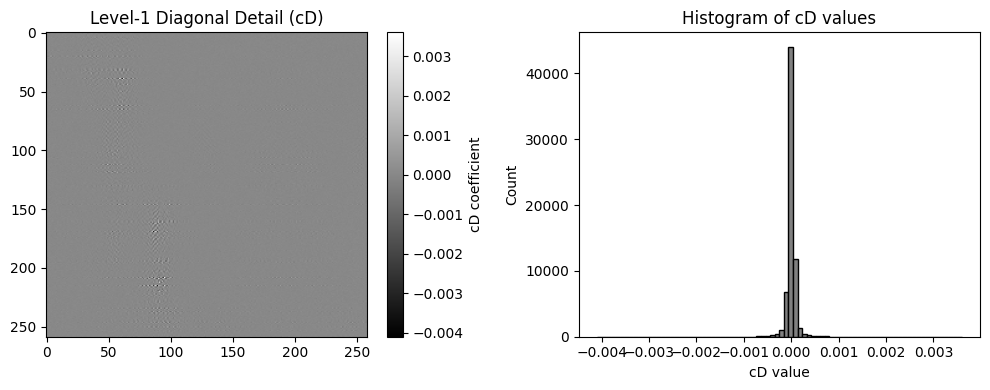


→ Now you can feed this σ̂ into your DDRM command, e.g.:
   --sigma_0 2.88


In [3]:
import numpy as np
import scipy.io
import pywt
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 1) LOAD YOUR PSF AND RF DATA
# ─────────────────────────────────────────────────────────────────────────────
psf_data = scipy.io.loadmat('exp/datasets/carotid/psf.mat')
psf = psf_data['psf'].astype(np.float64)
psf /= np.sum(np.abs(psf))

rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
rf = rf_mat['data'].astype(np.float64)    # shape (512,512), raw RF

# (Optional) Normalize RF to [0,1] or keep original dynamic range.
# If rf already has roughly zero‐mean and unit range, you can skip scaling.
# Here we normalize to [0,1] for stability in wavelet transform:
rf_norm = rf - rf.min()
rf_norm /= (rf_norm.max() + 1e-12)

# ─────────────────────────────────────────────────────────────────────────────
# 2) ONE‐LEVEL WAVELET DECOMPOSITION ON RF
# ─────────────────────────────────────────────────────────────────────────────
# Choose a Daubechies wavelet (db4 is a common choice)
wavelet_name = 'db4'
mode = 'symmetric'

# Perform single‐level 2D DWT
#   coeffs2 = (cA, (cH, cV, cD))
cA, (cH, cV, cD) = pywt.dwt2(rf_norm, wavelet=wavelet_name, mode=mode)

# cD is the diagonal detail subband (finest scale)
detail_coeffs = cD

# ─────────────────────────────────────────────────────────────────────────────
# 3) ESTIMATE σ VIA MAD ON cD
# ─────────────────────────────────────────────────────────────────────────────
# Median Absolute Deviation 
mad = np.median(np.abs(detail_coeffs - np.median(detail_coeffs)))
sigma_est = mad / 0.6745   # MAD→σ for Gaussian noise

print(f"Estimated σ̂ from RF (MAD on level‐1 cD): {sigma_est:.4f}")

# If you want σ in the **same scale as original RF**, multiply by the original range:
# For example, if rf_norm = (rf - min) / (max - min), then
rf_range = rf.max() - rf.min()
sigma_original_scale = sigma_est * rf_range
print(f"Estimated σ̂ (in original RF units): {sigma_original_scale:.4f}")

# ─────────────────────────────────────────────────────────────────────────────
# 4) OPTIONAL: VISUALIZE THE DIAGONAL DETAIL COEFFICIENTS
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(detail_coeffs, cmap='gray', aspect='auto')
plt.colorbar(label='cD coefficient')
plt.title('Level‐1 Diagonal Detail (cD)')

plt.subplot(1,2,2)
plt.hist(detail_coeffs.ravel(), bins=80, color='gray', edgecolor='black')
plt.title('Histogram of cD values')
plt.xlabel('cD value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 5) USING σ̂ IN DDRM
# ─────────────────────────────────────────────────────────────────────────────
print("\n→ Now you can feed this σ̂ into your DDRM command, e.g.:")
print(f"   --sigma_0 {sigma_original_scale:.2f}")


Estimated σ (linear RF units): 478.2217
Estimated σ (in dB): 53.59 dB


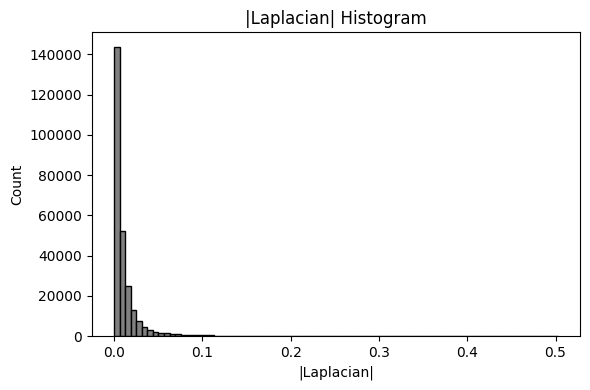

In [69]:
import numpy as np
import scipy.io
import cv2
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# 1) Load RF (no wavelets needed)
rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
rf = rf_mat['data'].astype(np.float64)   # shape (512,512)

# 2) Normalize RF to [0,1] so Laplacian response is stable
rf_min, rf_max = rf.min(), rf.max()
rf_norm = (rf - rf_min) / (rf_max - rf_min + 1e-12)

# 3) Compute absolute 2D Laplacian as a proxy for fine‐scale noise
laplacian = cv2.Laplacian(rf_norm, ddepth=cv2.CV_64F, ksize=3)
lap_abs = np.abs(laplacian)

# 4) MAD‐based sigma estimate in normalized domain
mad = np.median(lap_abs.ravel())
sigma_norm = mad / 0.6745   # σ in [0,1]

# 5) Scale σ back to original RF units
rf_range = rf_max - rf_min
sigma_linear = sigma_norm * rf_range

# 6) Convert σ to dB
sigma_db = 20.0 * np.log10(sigma_linear + 1e-12)

print(f"Estimated σ (linear RF units): {sigma_linear:.4f}")
print(f"Estimated σ (in dB): {sigma_db:.2f} dB")

# 7) (Optional) Plot lap_abs histogram for sanity check
plt.figure(figsize=(6,4))
plt.hist(lap_abs.ravel(), bins=80, color='gray', edgecolor='black')
plt.title("|Laplacian| Histogram")
plt.xlabel("|Laplacian|")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 8) Use σ_dB in DDRM if needed (some pipelines expect linear σ; if DDRM expects dB, pass sigma_db)
#    Example: python main.py ... --sigma_0 <sigma_db> ...


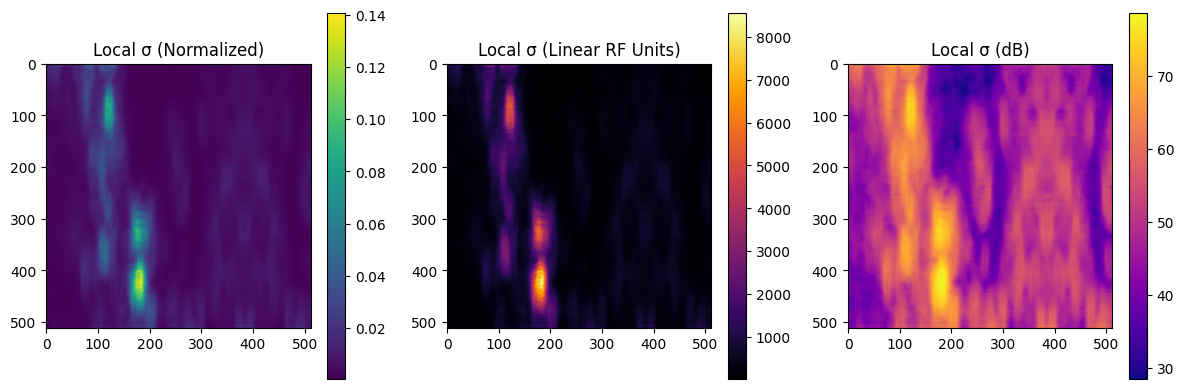

In [14]:
import numpy as np
import scipy.io
import cv2
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt

# 1. Load RF image
rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
rf = rf_mat['data'].astype(np.float64)

# 2. Normalize RF to [0,1]
rf_min, rf_max = rf.min(), rf.max()
rf_norm = (rf - rf_min) / (rf_max - rf_min + 1e-12)

# 3. Compute 2D Laplacian
laplacian = cv2.Laplacian(rf_norm, ddepth=cv2.CV_64F, ksize=3)
lap_abs = np.abs(laplacian)

# 4. Define local MAD filter (for window size 15×15)
def local_mad(x):
    return np.median(np.abs(x - np.median(x))) / 0.6745

window_size = 15  # Odd number (e.g., 11, 15, 21)
pad = window_size // 2

# Apply local MAD filter (normalized sigma)
sigma_norm_map = generic_filter(
    lap_abs, local_mad, size=window_size, mode='reflect'
)

# 5. Rescale to original RF units
rf_range = rf_max - rf_min
sigma_linear_map = sigma_norm_map * rf_range

# 6. Convert to dB
sigma_db_map = 20 * np.log10(sigma_linear_map + 1e-12)

# 7. Plot
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(sigma_norm_map, cmap='viridis')
plt.title('Local σ (Normalized)')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(sigma_linear_map, cmap='inferno')
plt.title('Local σ (Linear RF Units)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(sigma_db_map, cmap='plasma')
plt.title('Local σ (dB)')
plt.colorbar()

plt.tight_layout()
plt.show()


In [70]:
folder_name = "Carotidsigmadb"

In [76]:
!python main.py --ni --config deblur_carotid.yml --doc imagenet_ood --timesteps 20 --eta 0.85 --etaB 1 --deg deblur_bccb --sigma_0 53 -i {folder_name}

Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/Stable_DDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO - main.py - 2025-06-06 17:01:31,628 - Using device: cuda
INFO - main.py - 2025-06-06 17:01:31,630 - Writing log file to exp/logs/imagenet_ood
INFO - main.py - 2025-06-06 17:01:31,630 - Exp instance id = 559898
INFO - main.py - 2025-06-06 17:01:31,630 - Exp comment = 
building dataset from exp/carotid.txt
read meta done
Start from 0
  0%|                                                     | 0/1 [00:00

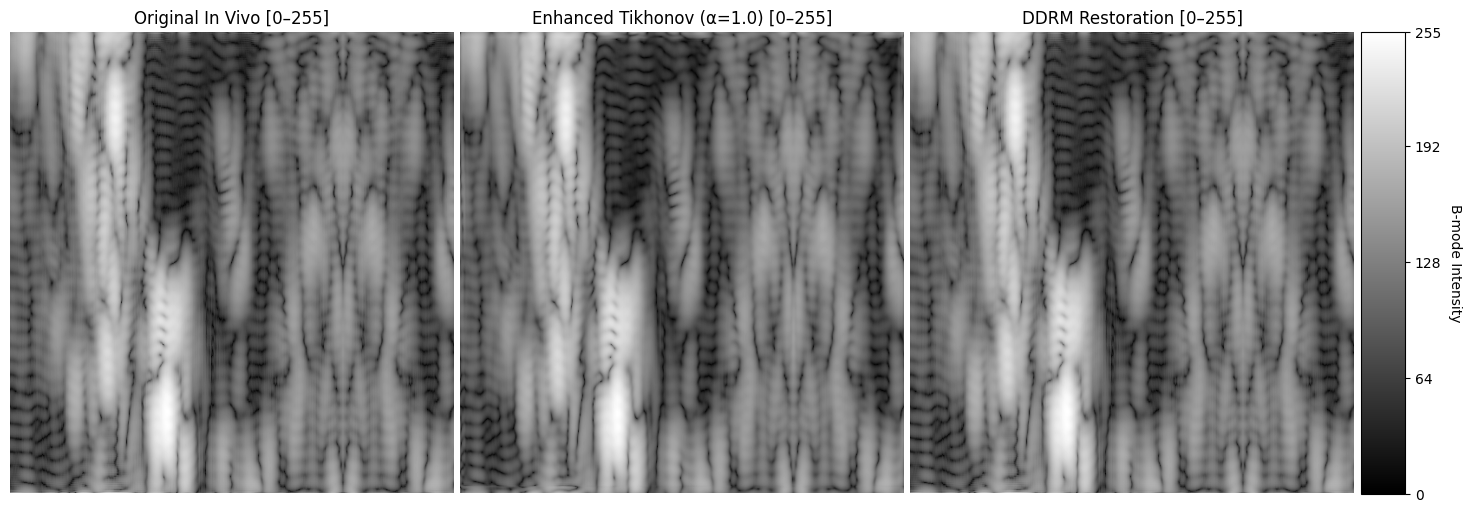


=== Quantitative Comparison vs. Original ===
Method			Contrast×	Sharpness×	SNR (dB)
------------------------------------------------------------
Tikhonov α=1.0      	1.00		1.00		14.52
DDRM                	1.00		1.00		31.70


In [78]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# ─────────────────────────────────────────────────────────────────────────────
# 1) LOAD PSF AND RF DATA
# ─────────────────────────────────────────────────────────────────────────────
psf_data = scipy.io.loadmat('exp/datasets/carotid/psf.mat')
psf = psf_data['psf'].astype(np.float64)
psf /= np.sum(np.abs(psf))

rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
data = rf_mat['data'].astype(np.float64)

# Normalize RF for Tikhonov
rfn = data / np.max(np.abs(data))

# Build the BCCB operator D (FFT of padded + centered PSF)
Mh, Nh = psf.shape
M, N = data.shape
pad_z, pad_x = M - Mh, N - Nh
pad_psf = np.pad(psf, ((0, pad_z), (0, pad_x)), mode='constant')

shift_y, shift_x = Mh//2, Nh//2
psf_shifted = np.roll(np.roll(pad_psf, -shift_y, axis=0), -shift_x, axis=1)
D = np.fft.fft2(psf_shifted)

# Compute RF‐domain for Original
RF = np.fft.fft2(rfn)
original_rf = np.fft.ifft2(RF).real

# ─────────────────────────────────────────────────────────────────────────────
# 2) LOAD DDRM RESTORED RF
# ─────────────────────────────────────────────────────────────────────────────
# (Assumes DDRM wrote a file "/mnt/data/0_-1.mat" with variable "image" of shape (C,H,W))
ddrm_mat = scipy.io.loadmat('exp/image_samples/Carotidsigmadb/0_-1.mat')
ddrm_img = ddrm_mat['image']                    # shape (C, H, W)
ddrm_img = np.transpose(ddrm_img, (1, 2, 0))    # → (H, W, C)
# Convert to grayscale if it’s 3‐channel:
ddrm_rf = np.mean(ddrm_img, axis=2)

# ─────────────────────────────────────────────────────────────────────────────
# 3) ENHANCED TIKHONOV (α = 1.0)
# ─────────────────────────────────────────────────────────────────────────────
def enhanced_tikhonov(RF, D, alpha=1.0, contrast_enhance=True):
    """
    RF : 2D FFT of normalized RF
    D  : 2D FFT of padded PSF (BCCB)
    alpha: Tikhonov regularization parameter
    """
    H = np.conj(D) / (np.abs(D)**2 + alpha)
    xf = RF * H
    restored = np.fft.ifft2(xf).real

    if contrast_enhance:
        orig_time = np.fft.ifft2(RF).real
        orig_energy = np.sum(orig_time**2)
        rest_energy = np.sum(restored**2)
        if rest_energy > 0:
            energy_ratio = np.sqrt(orig_energy / rest_energy)
            restored *= energy_ratio

        orig_std = np.std(orig_time)
        rest_std = np.std(restored)
        if rest_std > 0:
            contrast_ratio = orig_std / rest_std
            restored *= min(contrast_ratio, 2.0)

    return restored

enhanced_tk_1 = enhanced_tikhonov(RF, D, alpha=0.1)

# ─────────────────────────────────────────────────────────────────────────────
# 4) B-MODE CONVERSION (0 → 1)
# ─────────────────────────────────────────────────────────────────────────────
def to_bmode(im, offset=1e-3, dr=60):
    """
    Convert a 2D RF‐like image (positive or negative values) into 
    a log‐compressed B-mode in [0,1].
    """
    env = np.abs(hilbert(im, axis=0))
    if np.max(env) > 0:
        env /= np.max(env)
    log_env = 20 * np.log10(env + offset)
    log_env = np.clip(log_env, -dr, 0)
    return (log_env + dr) / dr

bmode_orig = to_bmode(original_rf)
bmode_tk1  = to_bmode(enhanced_tk_1)
bmode_ddrm = to_bmode(ddrm_rf)

# ─────────────────────────────────────────────────────────────────────────────
# 5) SCALE B-MODES TO [0 → 255] (uint8)
# ─────────────────────────────────────────────────────────────────────────────
bmode_orig_255 = np.round(bmode_orig * 255).astype(np.uint8)
bmode_tk1_255  = np.round(bmode_tk1  * 255).astype(np.uint8)
bmode_ddrm_255 = np.round(bmode_ddrm * 255).astype(np.uint8)

# ─────────────────────────────────────────────────────────────────────────────
# 6) DISPLAY ALL THREE SIDE-BY-SIDE + SEPARATE COLORBAR
# ─────────────────────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.02)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
cax = fig.add_subplot(gs[0, 3])

# Original
im0 = ax0.imshow(bmode_orig_255, cmap='gray', vmin=0, vmax=255, aspect='auto')
ax0.set_title("Original In Vivo [0–255]")
ax0.axis('off')

# Enhanced Tikhonov (α = 1.0)
im1 = ax1.imshow(bmode_tk1_255, cmap='gray', vmin=0, vmax=255, aspect='auto')
ax1.set_title("Enhanced Tikhonov (α=1.0) [0–255]")
ax1.axis('off')

# DDRM Restoration
im2 = ax2.imshow(bmode_ddrm_255, cmap='gray', vmin=0, vmax=255, aspect='auto')
ax2.set_title("DDRM Restoration [0–255]")
ax2.axis('off')

# Standalone colorbar for [0 → 255]
cbar = fig.colorbar(im2, cax=cax, orientation='vertical', ticks=[0, 64, 128, 192, 255])
cbar.set_label("B-mode Intensity", rotation=270, labelpad=15)

plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 7) QUANTITATIVE METRICS (vs. Original)
# ─────────────────────────────────────────────────────────────────────────────
def compare_metrics(reference, restored):
    ref_b = to_bmode(reference)
    res_b = to_bmode(restored)
    # Contrast ratio
    contrast_ratio = np.std(res_b) / (np.std(ref_b) + 1e-10)
    # Sharpness ratio (mean gradient magnitude)
    gr_ref = np.gradient(ref_b)
    gr_res = np.gradient(res_b)
    sharp_ref = np.mean(np.sqrt(gr_ref[0]**2 + gr_ref[1]**2))
    sharp_res = np.mean(np.sqrt(gr_res[0]**2 + gr_res[1]**2))
    sharpness_ratio = sharp_res / (sharp_ref + 1e-10)
    # SNR (variance-based)
    noise = ref_b - res_b
    snr = 10 * np.log10(np.var(res_b) / (np.var(noise) + 1e-10))
    return contrast_ratio, sharpness_ratio, snr

print("\n=== Quantitative Comparison vs. Original ===")
print("Method\t\t\tContrast×\tSharpness×\tSNR (dB)")
print("-" * 60)
for label, result in [("Tikhonov α=1.0", enhanced_tk_1), ("DDRM", ddrm_rf)]:
    c, s, snr = compare_metrics(original_rf, result)
    print(f"{label:<20}\t{c:.2f}\t\t{s:.2f}\t\t{snr:.2f}")


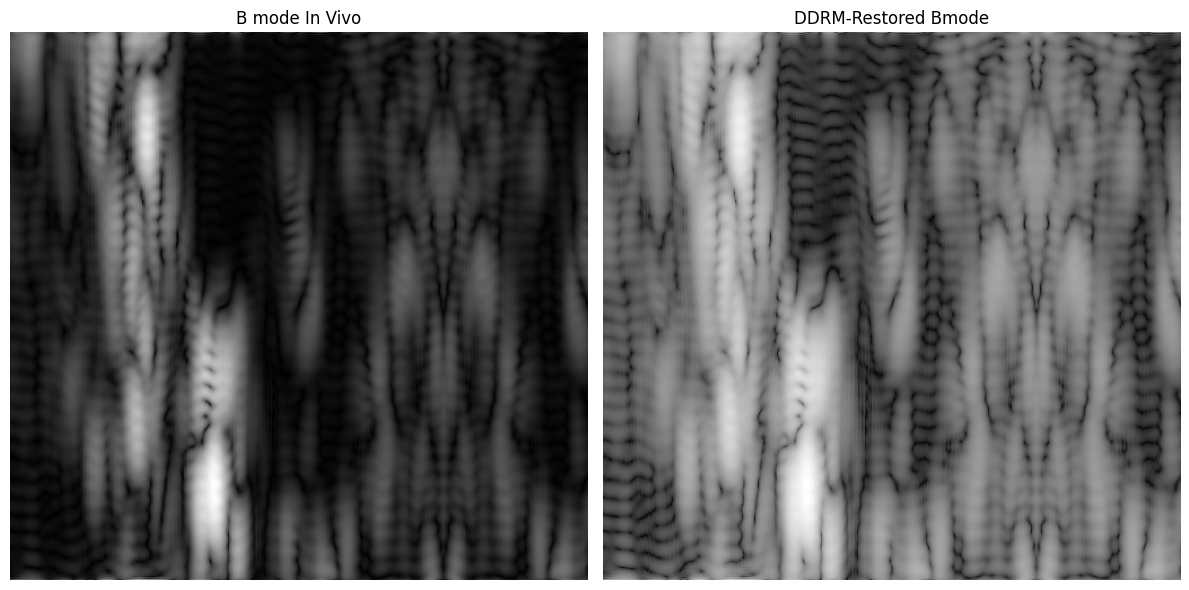

In [13]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# ─────────────────────────────────────────────────────────────────────
# Load Original RF
# ─────────────────────────────────────────────────────────────────────
rf_mat = scipy.io.loadmat('exp/datasets/carotid/rf_512.mat')
rf_orig = rf_mat['data'].astype(np.float64)

# Envelope and Log Compression
env_orig = np.abs(hilbert(rf_orig, axis=0))
logB = 1000
bmode_orig = np.log(env_orig + logB)

# ─────────────────────────────────────────────────────────────────────
# Load DDRM-Restored RF
# ─────────────────────────────────────────────────────────────────────
ddrm_mat = scipy.io.loadmat("exp/image_samples/Carotidsigmadb/0_-1.mat")
ddrm = ddrm_mat["image"]                   # (C, H, W)
ddrm = np.transpose(ddrm, (1, 2, 0))       # → (H, W, C)
rf_ddrm = np.mean(ddrm, axis=2)            # → grayscale

# Envelope and Log Compression
env_ddrm = np.abs(hilbert(rf_ddrm, axis=0))
bmode_ddrm = np.log(env_ddrm + logB)

# ─────────────────────────────────────────────────────────────────────
# Plot Side by Side
# ─────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
im1 = plt.imshow(bmode_orig, cmap='gray', aspect='auto')
plt.title('B mode In Vivo')
plt.axis('off')

plt.subplot(1, 2, 2)
im2 = plt.imshow(bmode_ddrm, cmap='gray', aspect='auto')
plt.title('DDRM-Restored Bmode')
plt.axis('off')


plt.tight_layout()
plt.show()
